# Visual 

In [14]:
base = "data"
dataset = "nist"
kind = "in_database"

data_train_path =f"{base}/{dataset}/{kind}/train.msp"
data_val_path =f"{base}/{dataset}/{kind}/val.msp"
data_test_path =f"{base}/{dataset}/{kind}/test.msp"

max_mz = 1001
probs = [0, .05, .1, .15, .2, .25, .3, .35, .4, .45, .5]

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
from matchms.importing import load_from_msp
from data_utils import spectrum_processing, get_n_samples, FixedSizeDS
from helpers import get_mz_vector, get_his_size
import numpy as np
from scipy.sparse import csr_matrix
from visual_utils import plot_spectrum_sample_prediction

# only for visual 
from spec2vec import SpectrumDocument
from data_utils import BasicCoder

In [4]:
def get_spectra(path):
    # Load data from MSP file and apply filters
    spectrums = [spectrum_processing(s, min_rel_int=None) for s in load_from_msp(path)]
    # Omit spectrums that didn't qualify for analysis
    spectrums = [s for s in spectrums if s is not None]
    # Create spectrum documents
    return spectrums
spectrums_train = get_spectra(data_train_path)
spectrums_val = get_spectra(data_val_path)
spectrums_test = get_spectra(data_test_path)

In [5]:
documents_test = [SpectrumDocument(s, n_decimals=0) for s in spectrums_test]

In [6]:
datasets_indb = {
    "spec_train": spectrums_train, 
    "spec_val": spectrums_val, 
    "spec_val_5000": get_n_samples(spectrums_val, 5000),
    "spec_val_10000": get_n_samples(spectrums_val, 10000),
    "spec_test": spectrums_test, 
    "fixed_test": FixedSizeDS(spectrums_test)
}


In [7]:
base = "data"
dataset = "nist"
kind = "de_novo"

data_train_path =f"{base}/{dataset}/{kind}/train.msp"
data_val_path =f"{base}/{dataset}/{kind}/val.msp"
data_test_path =f"{base}/{dataset}/{kind}/test.msp"

max_mz = 1001

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
spectrums_train = get_spectra(data_train_path)
spectrums_val = get_spectra(data_val_path)
spectrums_test = get_spectra(data_test_path)

In [9]:
documents_test = [SpectrumDocument(s, n_decimals=0) for s in spectrums_test]

In [10]:
datasets_denovo = {
    "spec_train": spectrums_train, 
    "spec_val": spectrums_val, 
    "spec_val_5000": get_n_samples(spectrums_val, 5000),
    "spec_val_10000": get_n_samples(spectrums_val, 10000),
    "spec_test": spectrums_test, 
    "fixed_test": FixedSizeDS(spectrums_test)
}


# TO mz

In [15]:
from gensim.models import Word2Vec
from model_evaluation import model_selection, model_selection_random
wv_path_indb = f"gas2vec/in_database.model"
wv_path_dn = f"gas2vec/de_novo.model"


w2v_indb = Word2Vec.load(wv_path_indb)
w2v_dn = Word2Vec.load(wv_path_dn)

In [12]:
def ids_to_mz(xs, i2e):
    res = []
    for x in xs:
        res.append(int(i2e[int(x)].split("@")[-1]))
    return np.array(res)

## indb


In [20]:
i2e = w2v_indb.wv.index2entity
_, scores_gpt = model_selection("predictions/in_database", "hugg_test", kw="gpt2", up_to_k=30, \
                                      l=4, j=6, to_rel_inten=.2, l_rel=None, return_details=True)

gpt2_ns_auto
Possible k up to 30, predict up to 20 peaks
Selected up to k=30, l=4, j=6
Selected up to k=30, l=None, to_rel_inten=0.2
[21122 22328 22520 22555 22561 22559 22562 22562 22563 22530 22501 22451
 22407 22354 22277 22205 22122 22016 21919 21799 21656 21519 21381 21214
 21040 20846 20638 20437 20264 20044]


In [21]:
preds, ys = scores_gpt["gpt2_ns_auto"]["dets"]["all"].values()

In [35]:
def plot_beauty(ds, i, k, preds, ys, i2e, kw="nic", kind="in_database", topk=True):
    spec = ds[i]
    if topk:
        missing_ind = np.argsort(spec.peaks.intensities)[::-1][k:]
        missing_mz = spec.peaks.mz[missing_ind]
    else:
        missing_mz = []
    if topk:
        k = k-1
    pred = preds[k][i]
    y = ys[k][i]
    if y is None or pred is None:
        print("not enough peaks")
        return
   
    if topk:
        pred = ids_to_mz(pred, i2e)
        y = ids_to_mz(y, i2e)
    
    TP = set(y).intersection(pred)
    FN = set(y).difference(pred)
    FP = set(pred).difference(y)
    
    plot_spectrum_sample_prediction(spec, missing_mz=missing_mz, TP_mz=TP, FN_mz=FN, FP_mz=FP,\
                                    max_mz=1001, \
                                    save_to_path=f"figures/{kind}/treecol/{kw}-{i}-{k}.pdf")

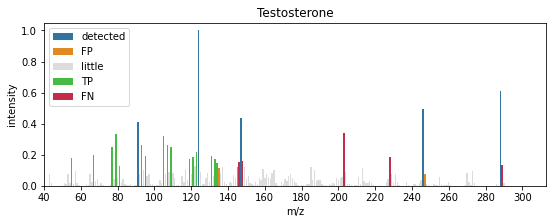

In [55]:
plot_beauty(datasets_indb["spec_test"], 17965, 5, preds, ys, i2e)

13325 3


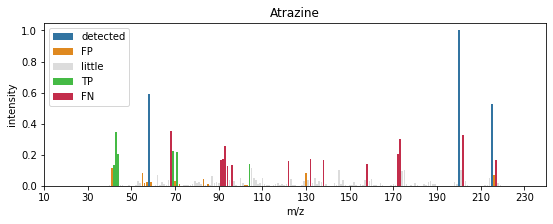

13325 4


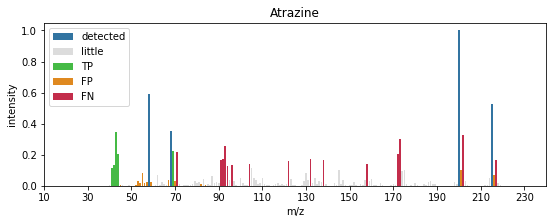

13325 5


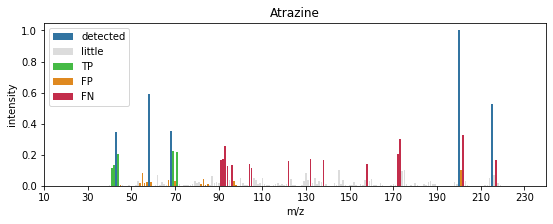

13325 6


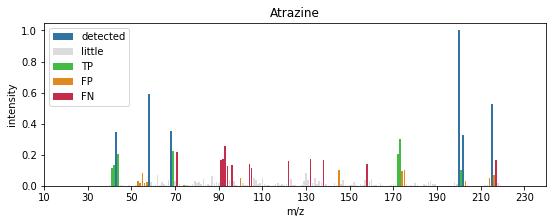

13325 7


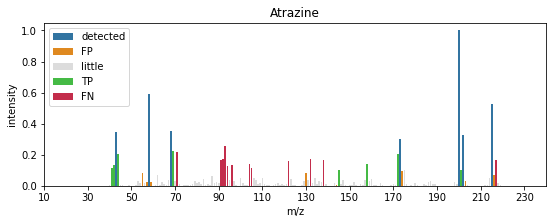

13326 3


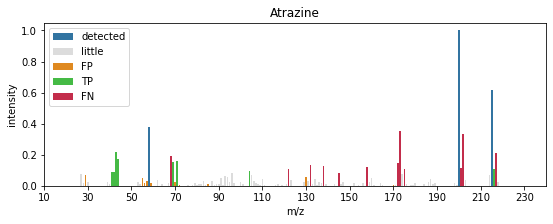

13326 4


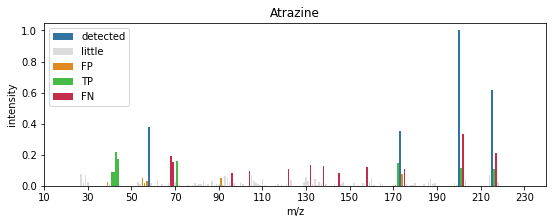

13326 5


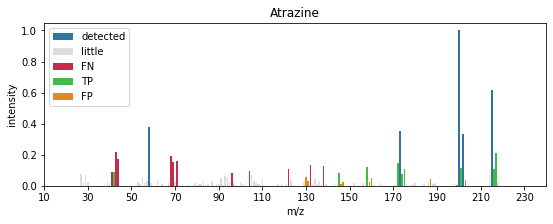

13326 6


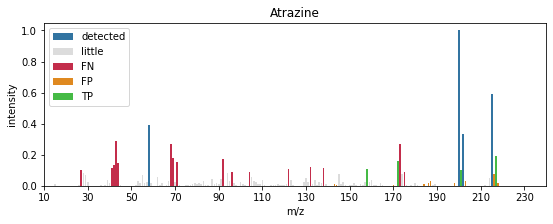

13327 5


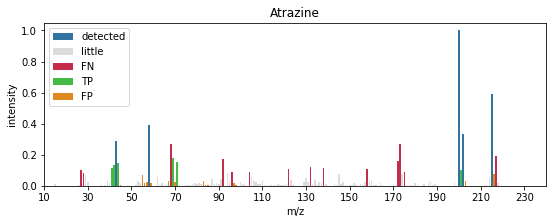

13327 6


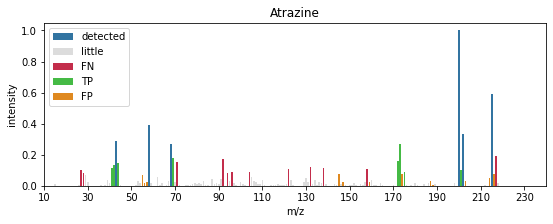

13327 7


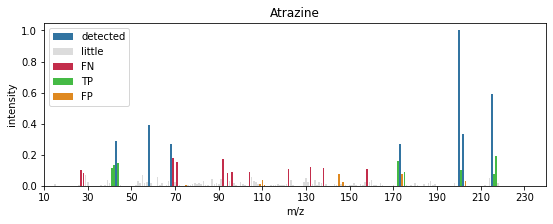

13328 3


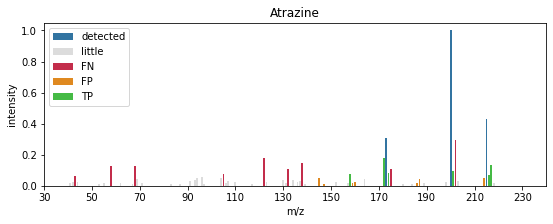

13328 4


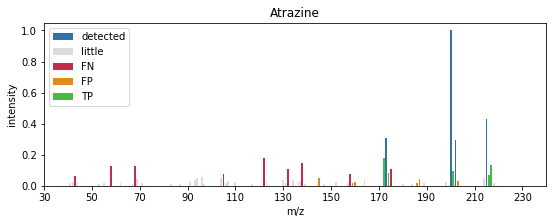

13328 5


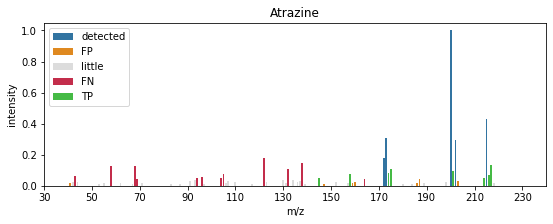

13328 6


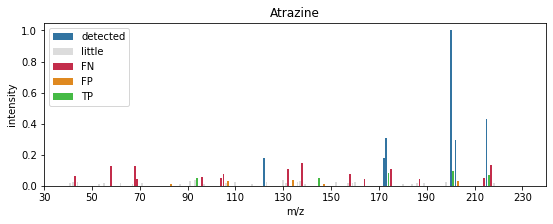

13328 7


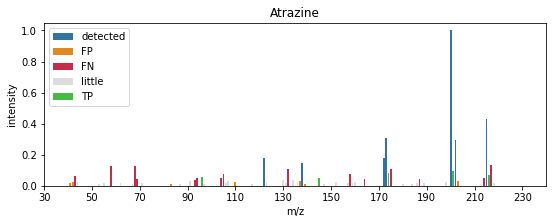

13765 3


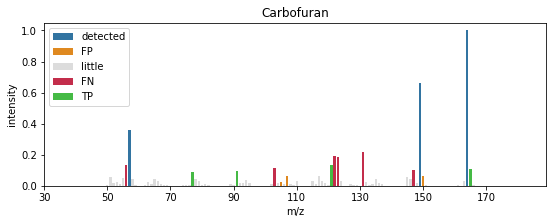

13765 4


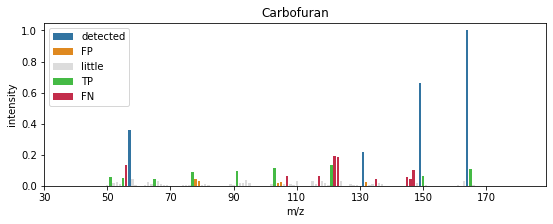

13765 5


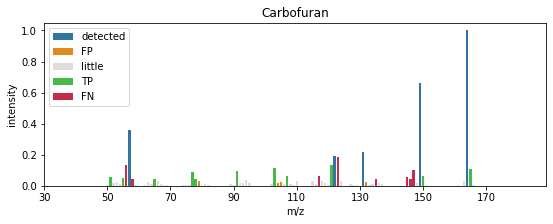

13765 6


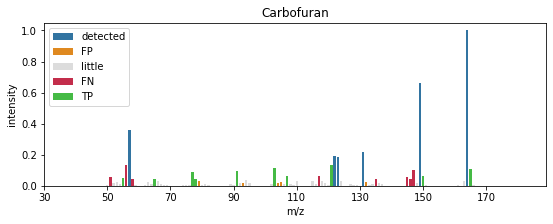

13765 7


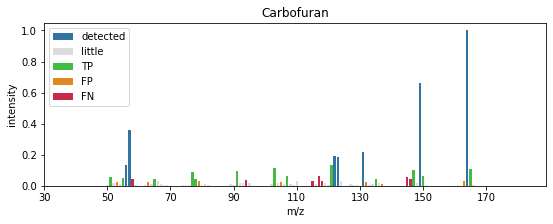

13766 3


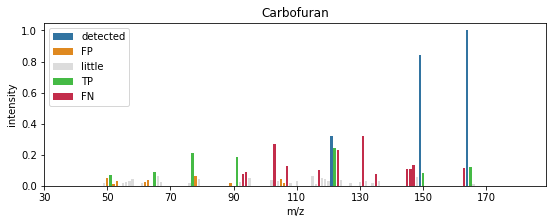

13766 4


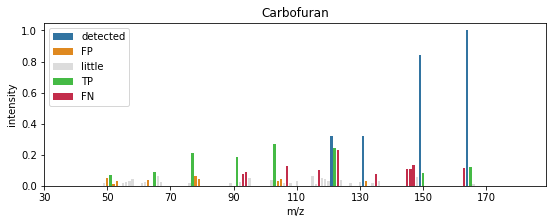

13766 5


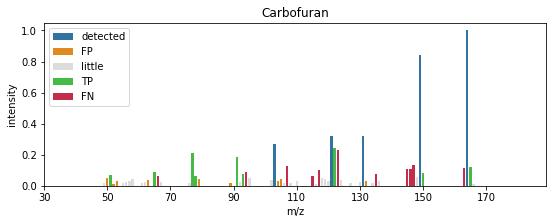

13766 6


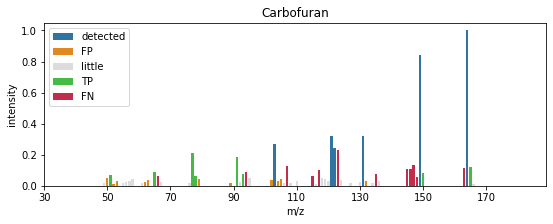

13766 7


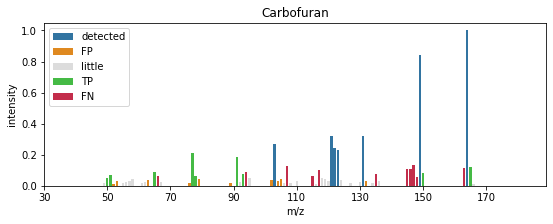

13767 3


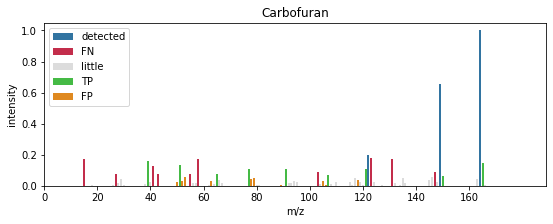

13767 4


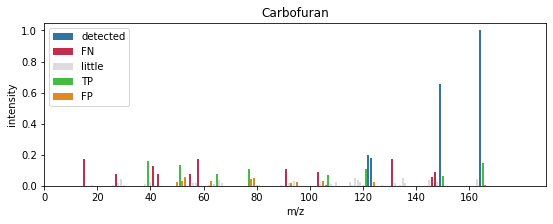

13767 5


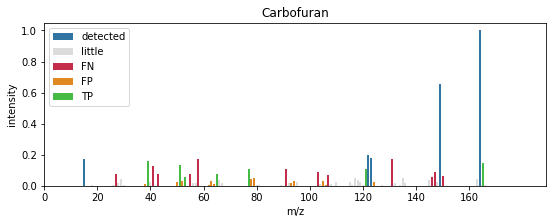

13767 6


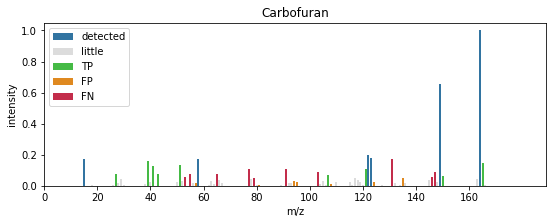

13767 7


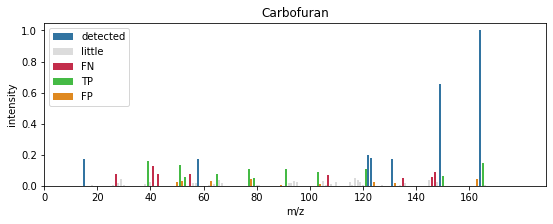

13768 3


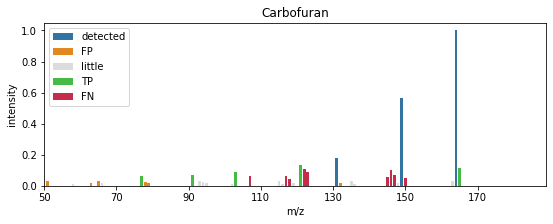

13768 4


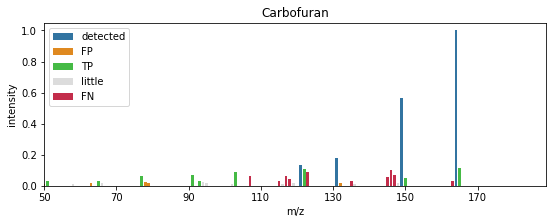

13768 5


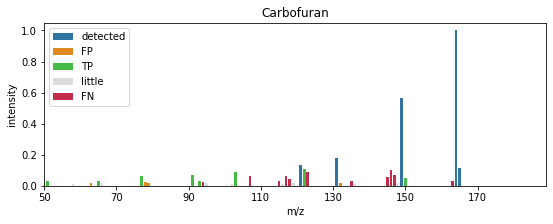

13768 6


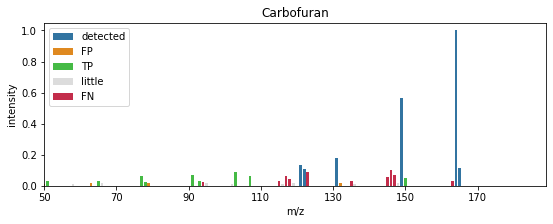

13768 7


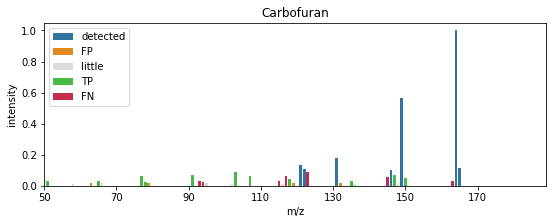

14046 3


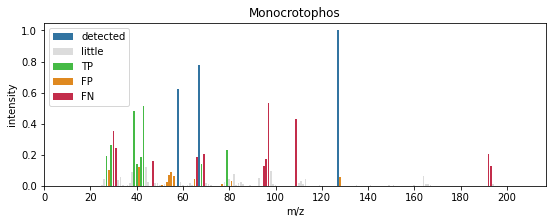

14046 4


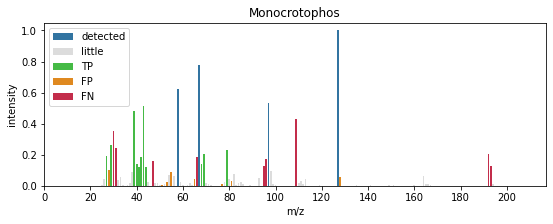

14046 5


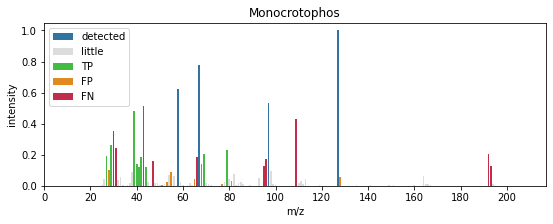

14046 6


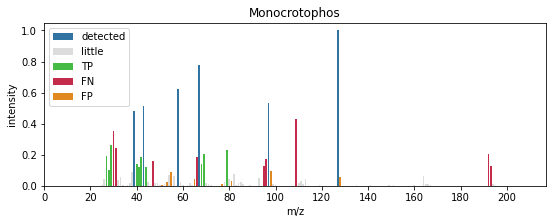

14046 7


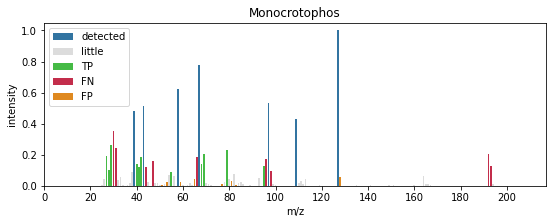

14047 3


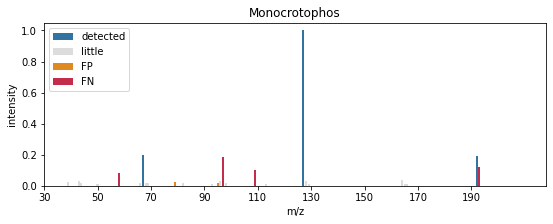

14047 4


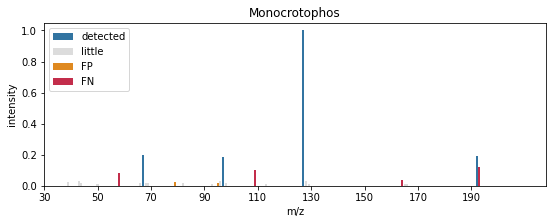

14047 5


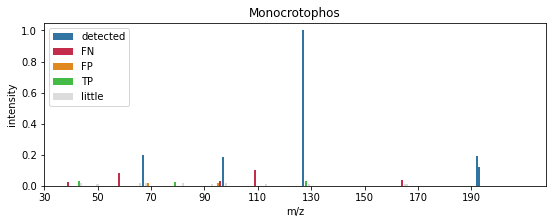

14047 6


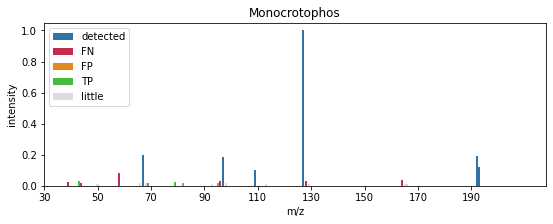

14047 7


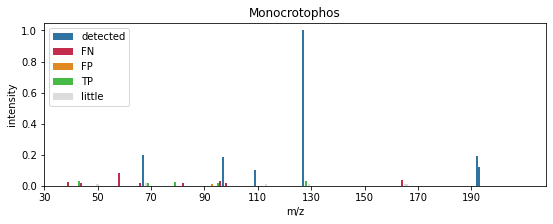

14149 3


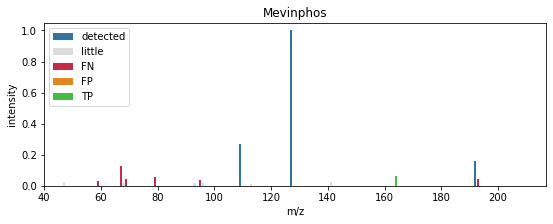

14149 4


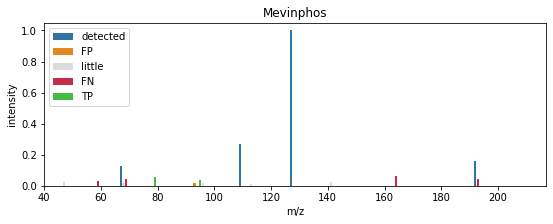

14149 5


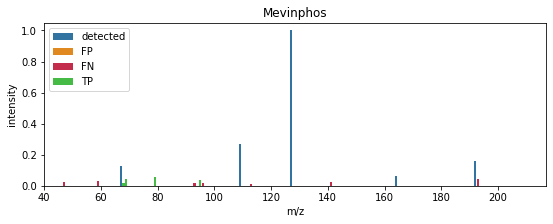

14149 6


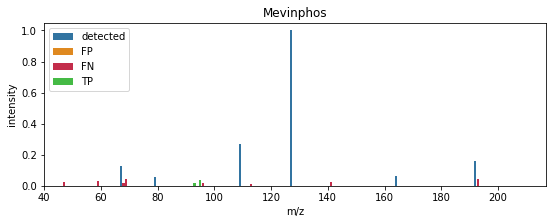

14149 7


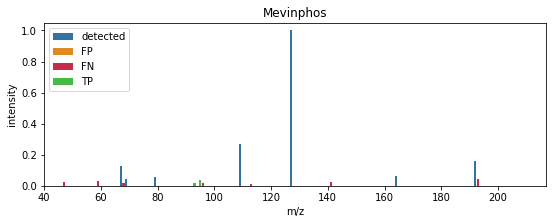

14150 3


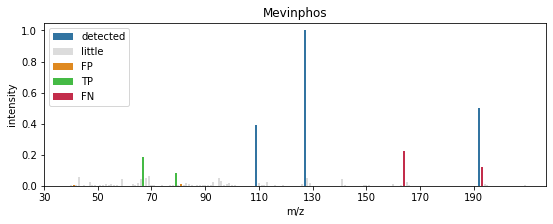

14150 4


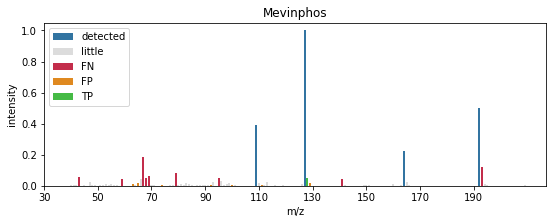

14150 5


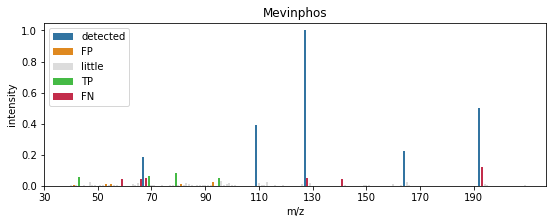

14150 6


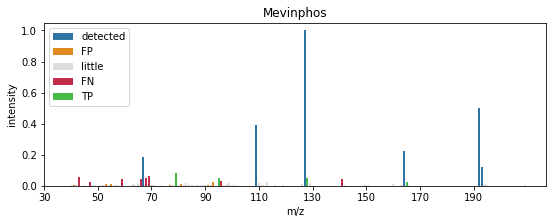

14150 7


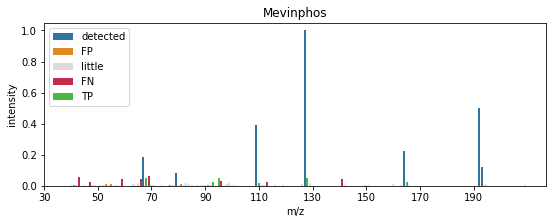

17961 3


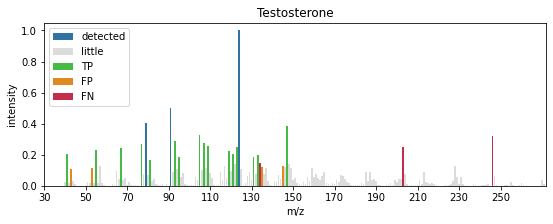

17961 4


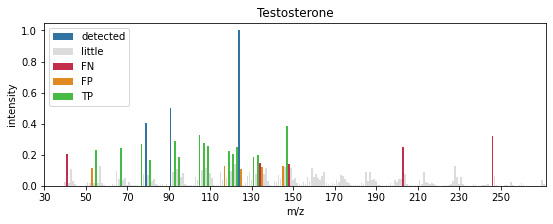

17961 5


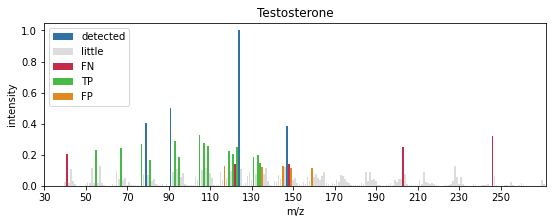

17961 6


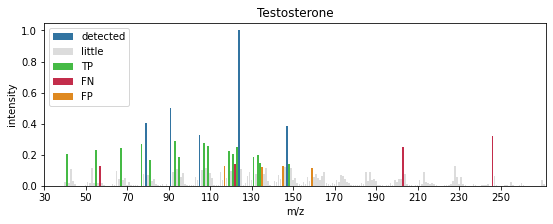

17961 7


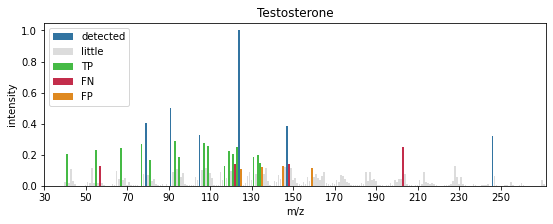

17962 3


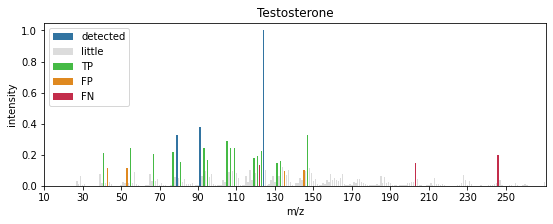

17962 4


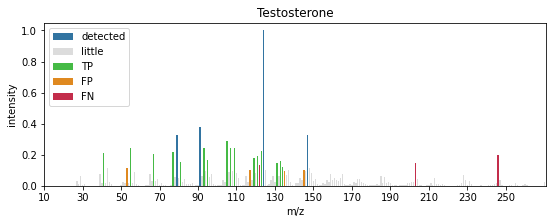

17962 5


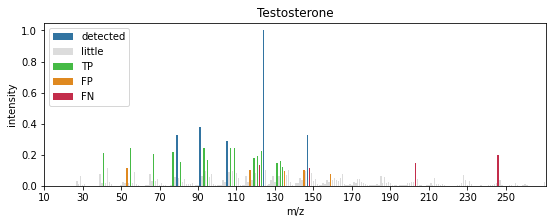

17962 6


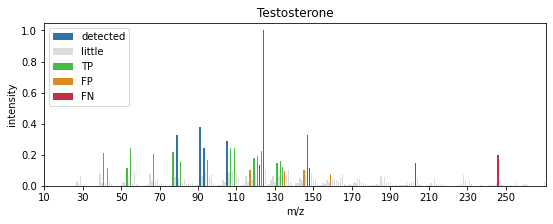

17962 7


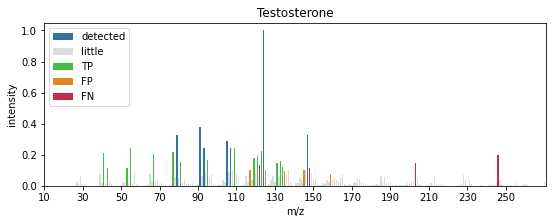

17963 3


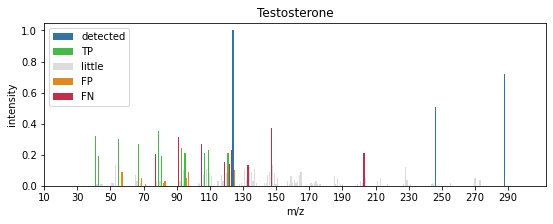

17963 4


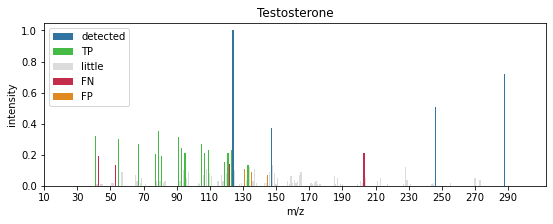

17963 5


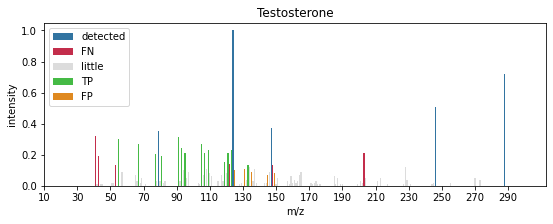

17963 6


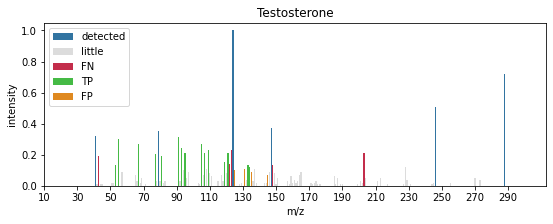

17963 7


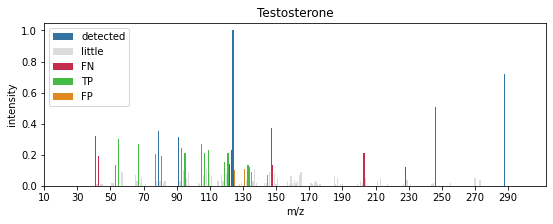

17964 3


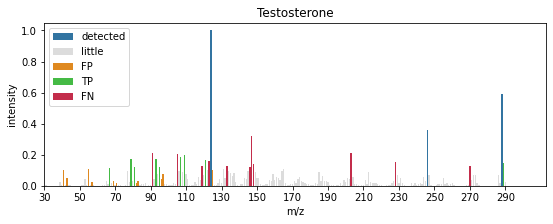

17964 4


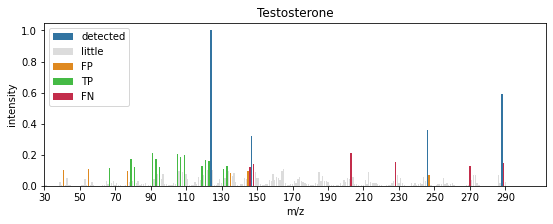

17964 5


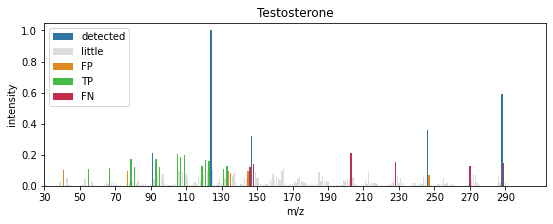

17964 6


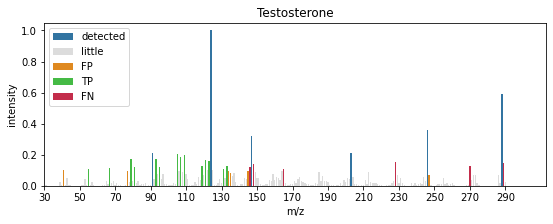

17964 7


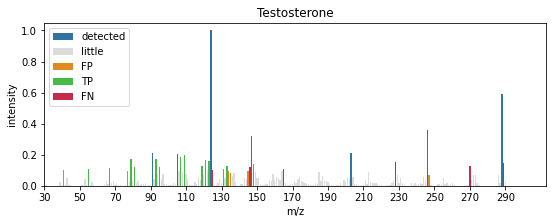

17965 3


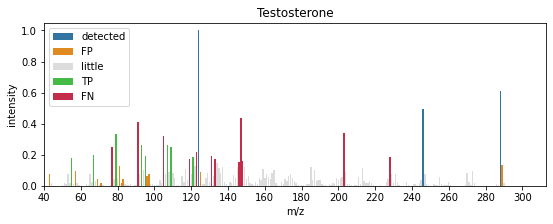

17965 4


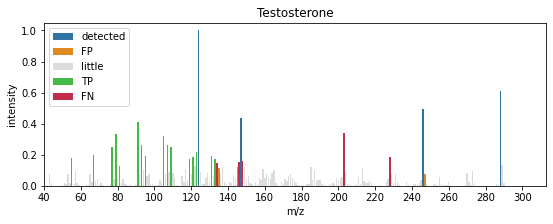

17965 5


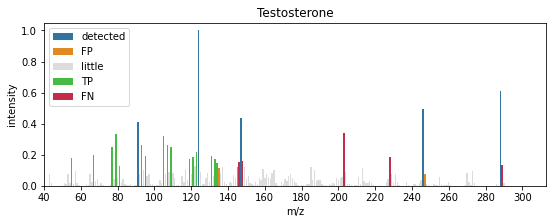

17965 6


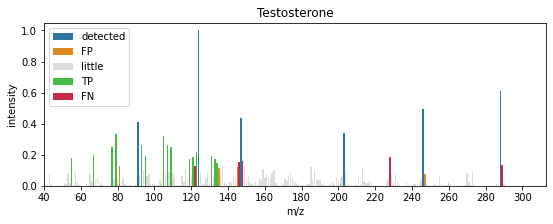

17965 7


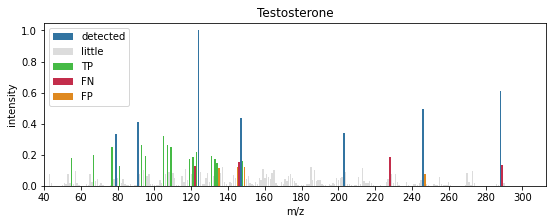

In [58]:
interesting =  ["Atrazine", "Carbofuran", "Monocrotophos", "Mevinphos", "Testosterone"]
for i in range(len(datasets_indb["spec_test"])):
    if datasets_indb["spec_test"][i].metadata["name"] in interesting:
        for k in [3,4,5,6,7]:
            print(i,k)
            plot_beauty(datasets_indb["spec_test"], i, k, preds, ys, i2e)

In [34]:
i2e = w2v_indb.wv.index2entity
_, scores_mlp = model_selection_random("predictions/in_database", "fixed_test", kw="mlp_2", return_details=True)

mlp_2_.3


/auto/brno6/home/xstary1/raims/metrics.py:232: RuntimeWarning: Mean of empty slice
  "mp": np.nanmean(recs_some, axis=1),
/auto/brno6/home/xstary1/raims/metrics.py:234: RuntimeWarning: Mean of empty slice
  "mf1": np.nanmean(f1_some, axis=1),
/auto/brno6/home/xstary1/raims/metrics.py:235: RuntimeWarning: Mean of empty slice
  "mps": np.nanmean(precs_m, axis=1)


In [36]:
preds, ys = scores_mlp["mlp_2_.3"]["all"].values()

13325 0


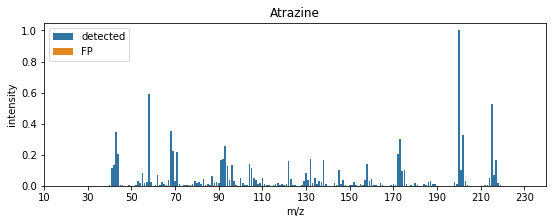

13325 0.05


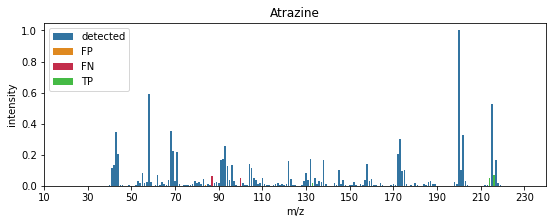

13325 0.1


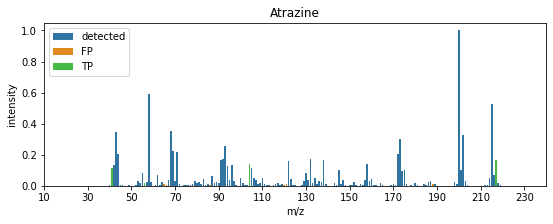

13325 0.15


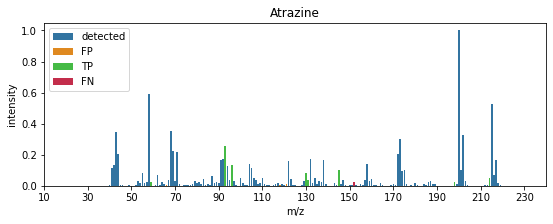

13325 0.2


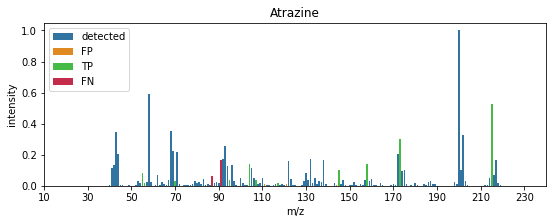

13325 0.25


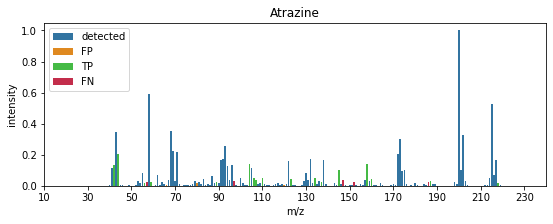

13325 0.3


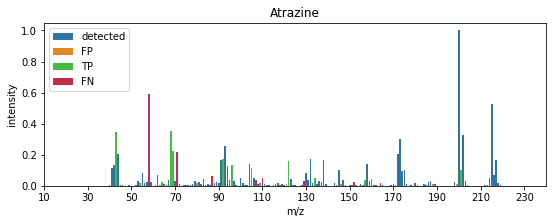

13325 0.35


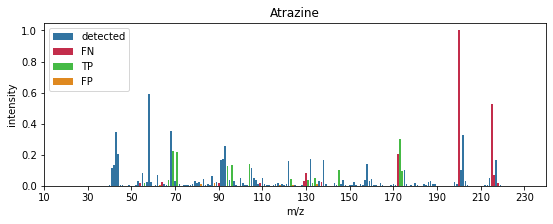

13325 0.4


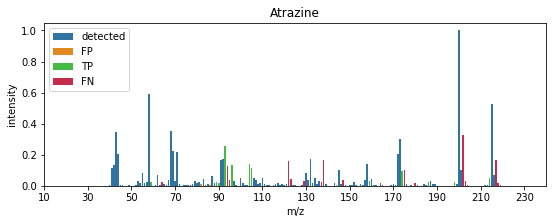

13325 0.45


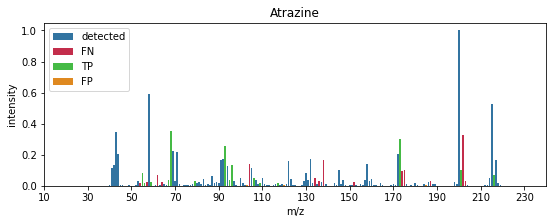

13325 0.5


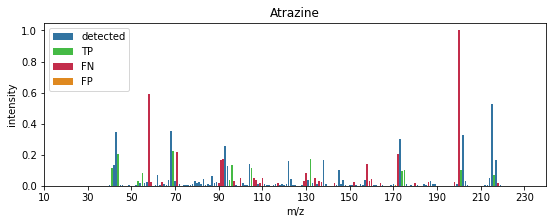

13326 0


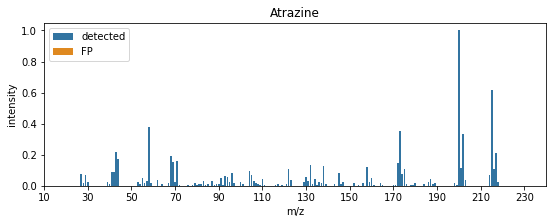

13326 0.05


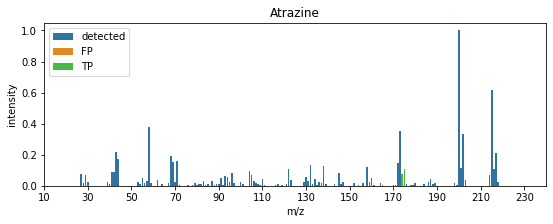

13326 0.1


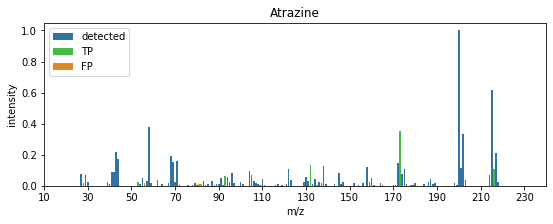

13326 0.15


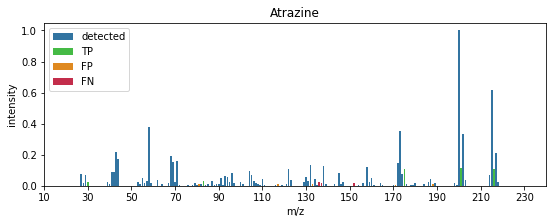

13326 0.2


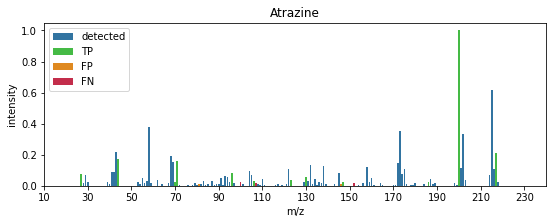

13326 0.25


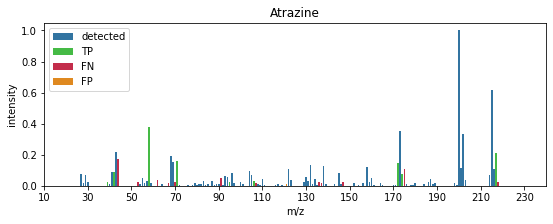

13326 0.3


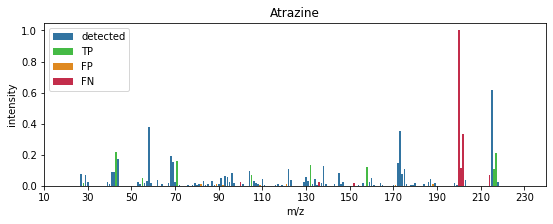

13326 0.35


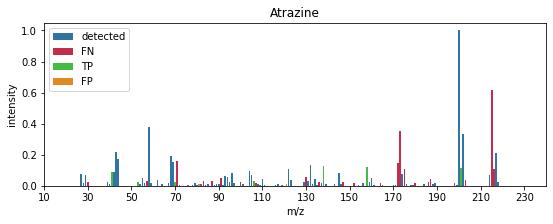

13326 0.4


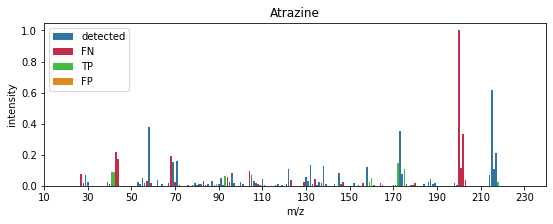

13326 0.45


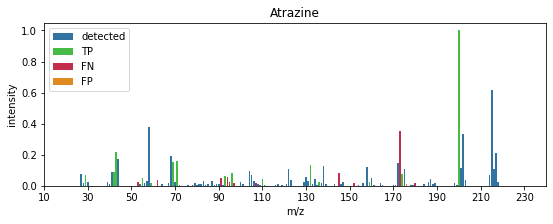

13326 0.5


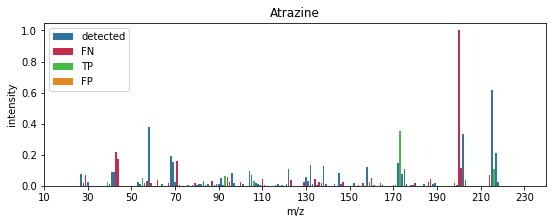

13327 0


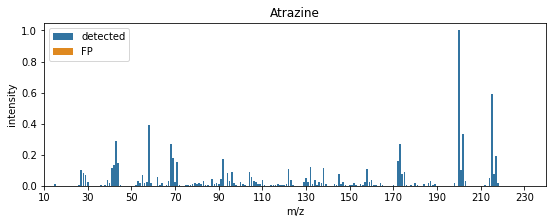

13327 0.05


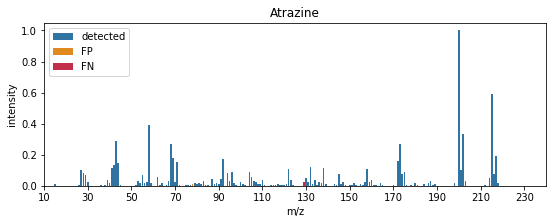

13327 0.1


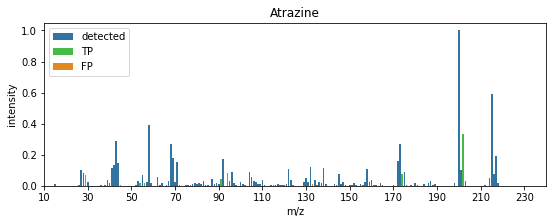

13327 0.15


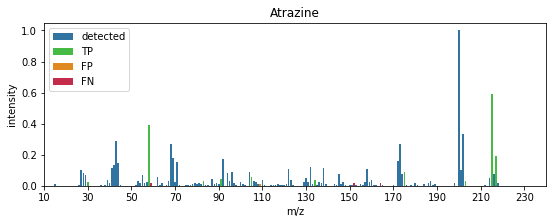

13327 0.2


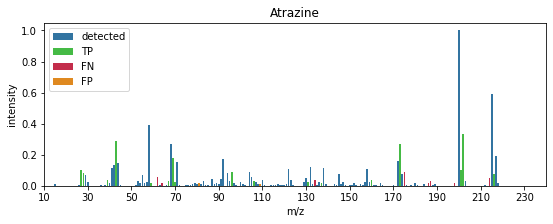

13327 0.25


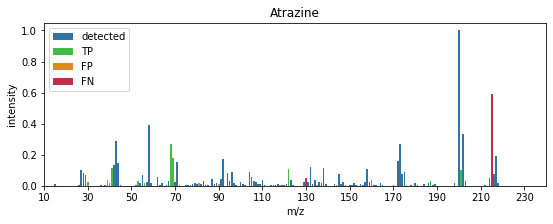

13327 0.3


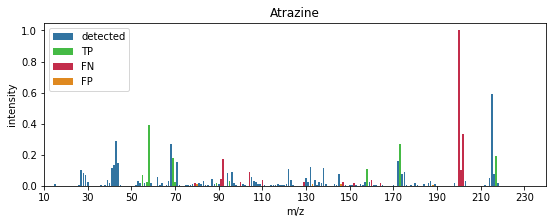

13327 0.35


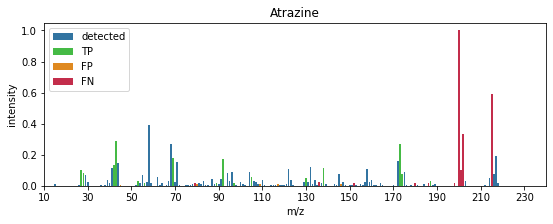

13327 0.4


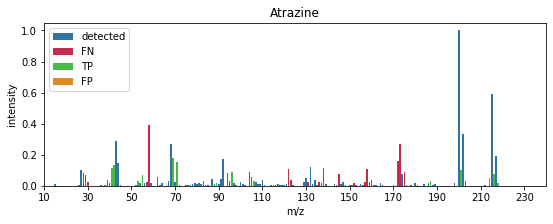

13327 0.45


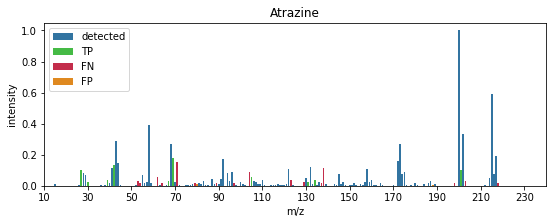

13327 0.5


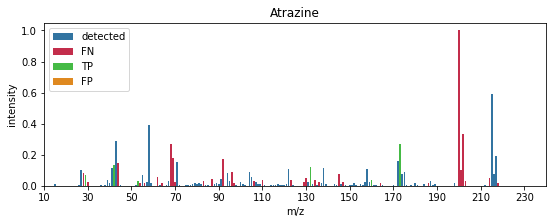

13328 0


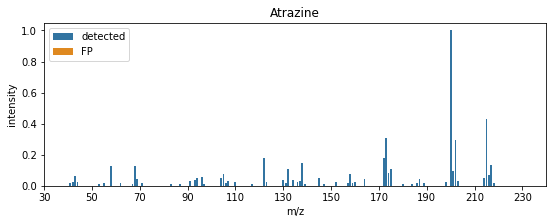

13328 0.05


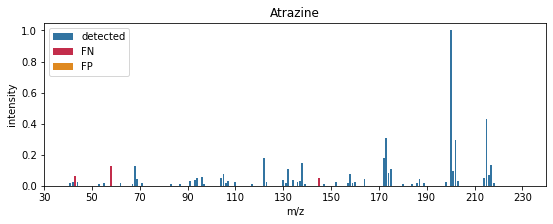

13328 0.1


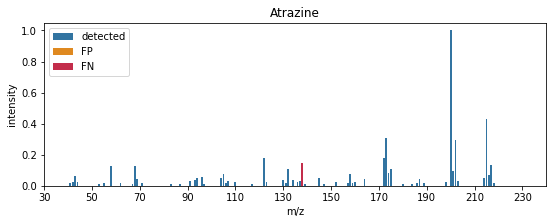

13328 0.15


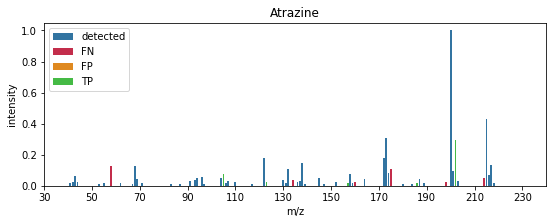

13328 0.2


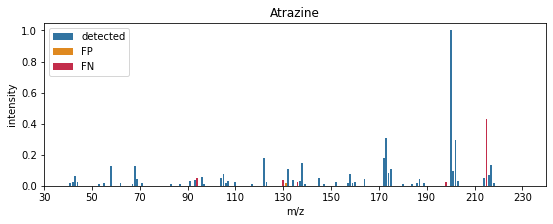

13328 0.25


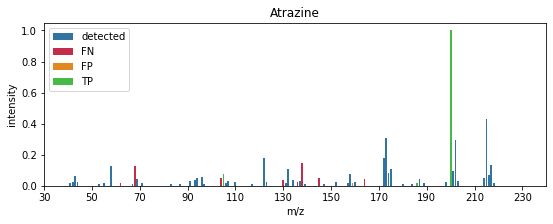

13328 0.3


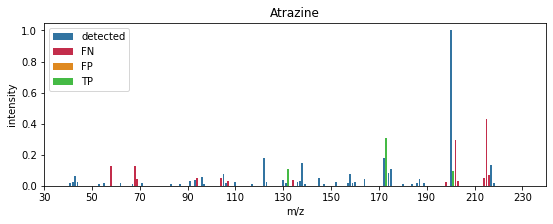

13328 0.35


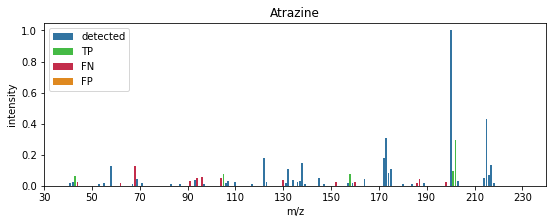

13328 0.4


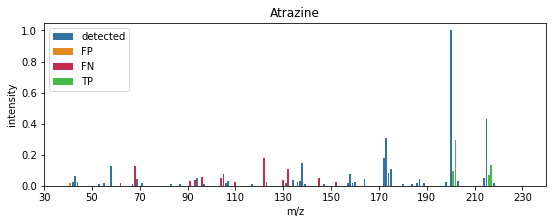

13328 0.45


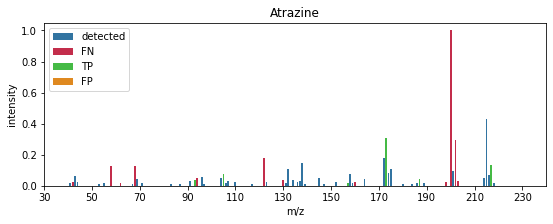

13328 0.5


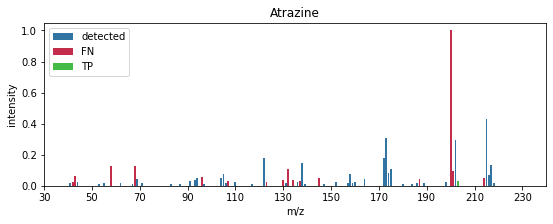

13765 0


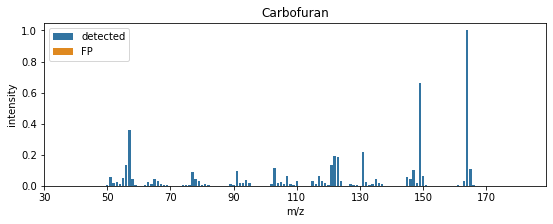

13765 0.05


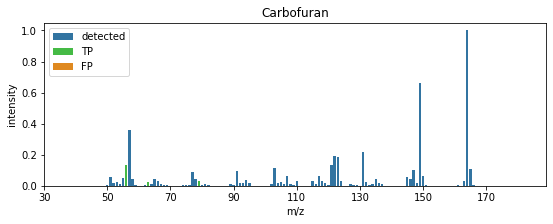

13765 0.1


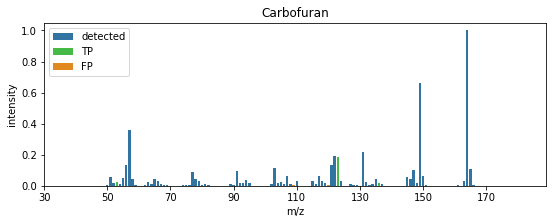

13765 0.15


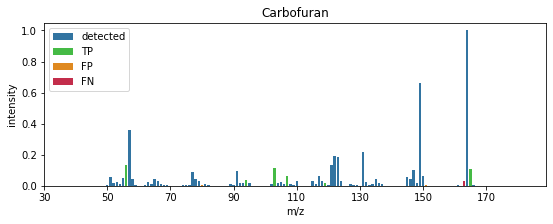

13765 0.2


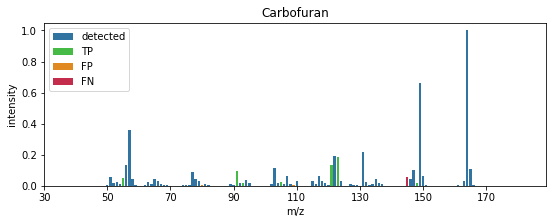

13765 0.25


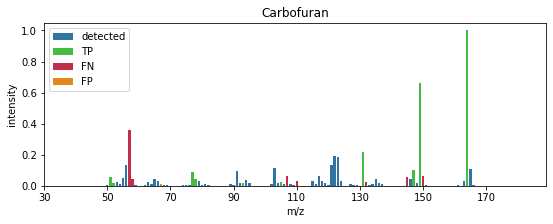

13765 0.3


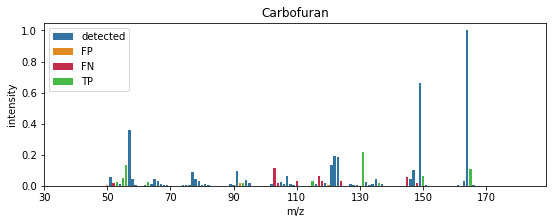

13765 0.35


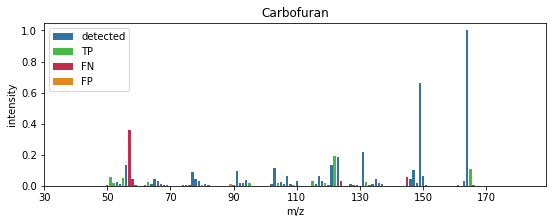

13765 0.4


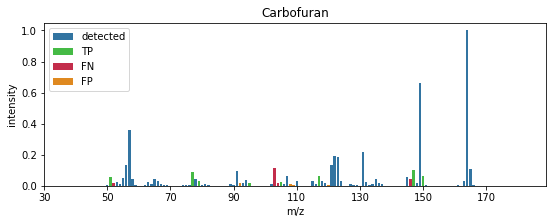

13765 0.45


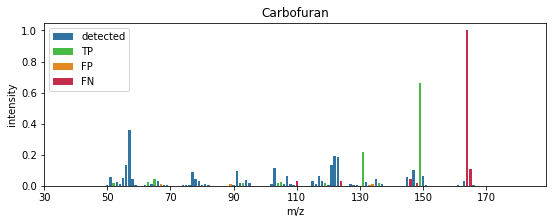

13765 0.5


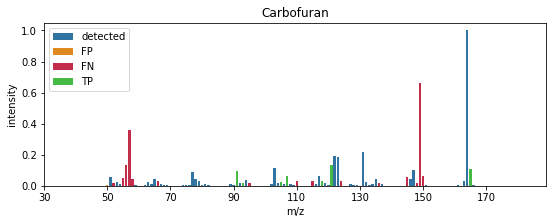

13766 0


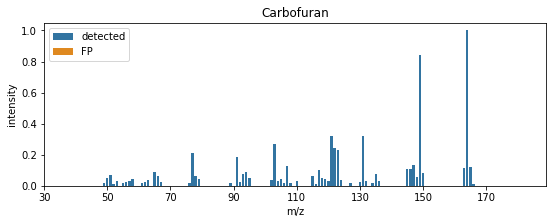

13766 0.05


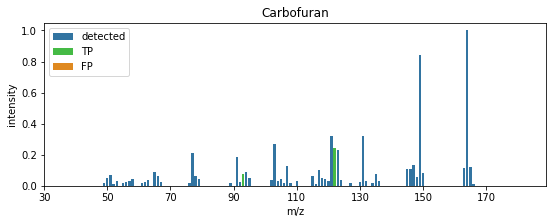

13766 0.1


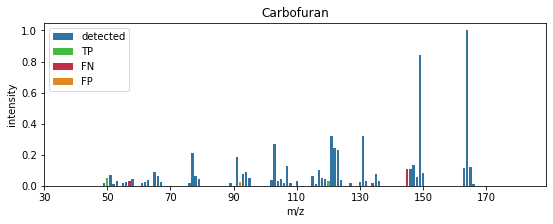

13766 0.15


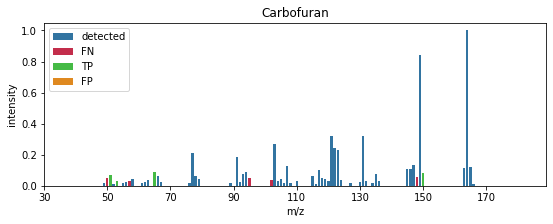

13766 0.2


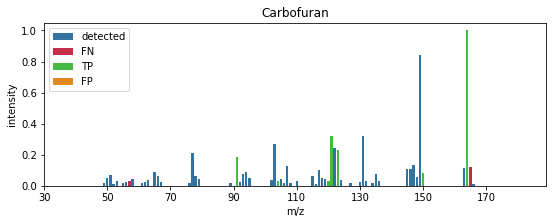

13766 0.25


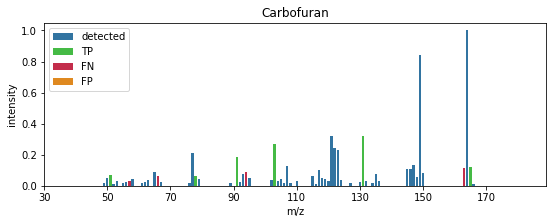

13766 0.3


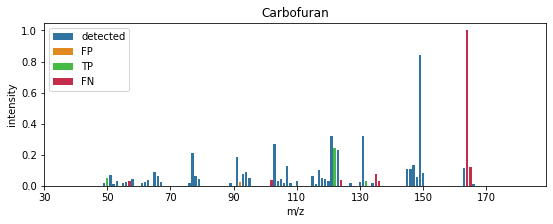

13766 0.35


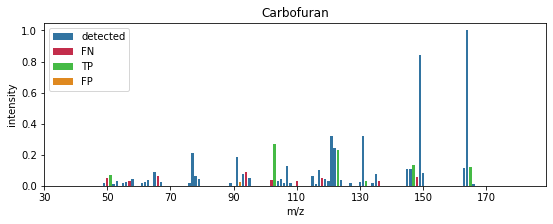

13766 0.4


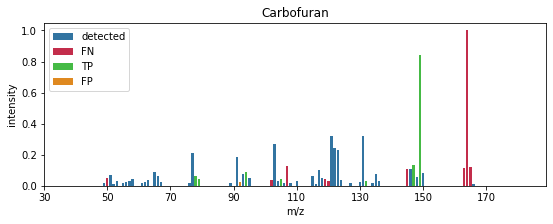

13766 0.45


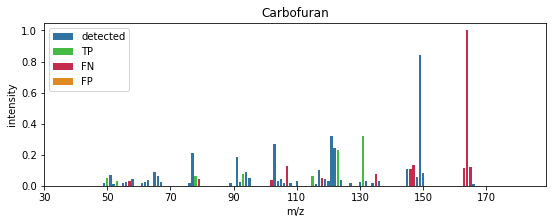

13766 0.5


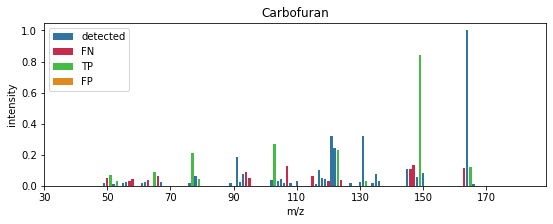

13767 0


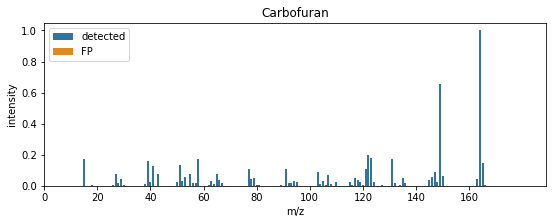

13767 0.05


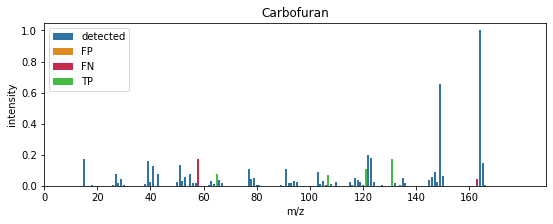

13767 0.1


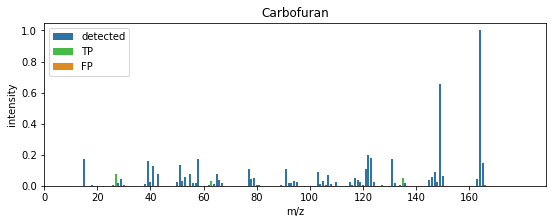

13767 0.15


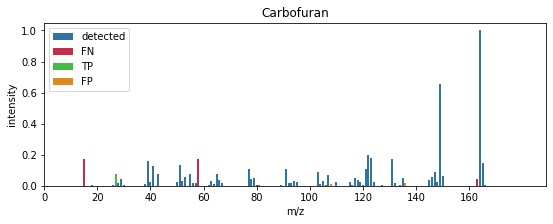

13767 0.2


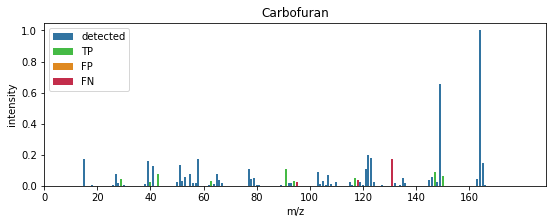

13767 0.25


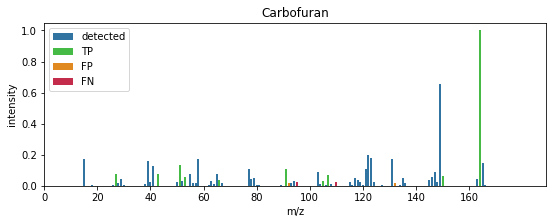

13767 0.3


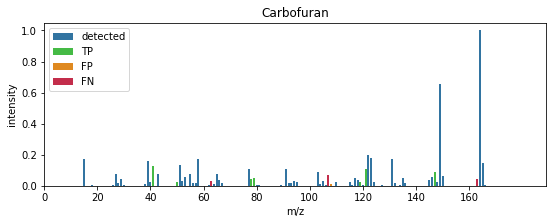

13767 0.35


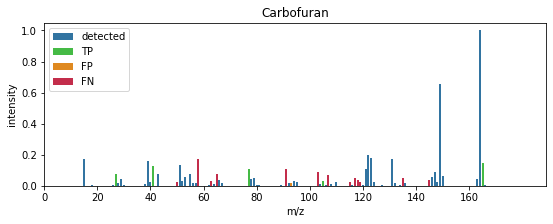

13767 0.4


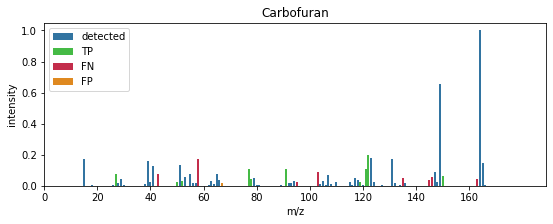

13767 0.45


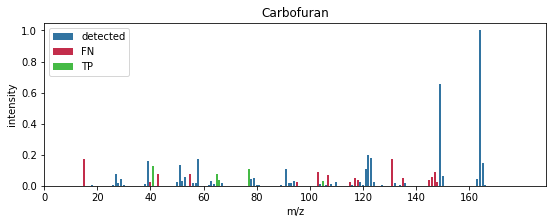

13767 0.5


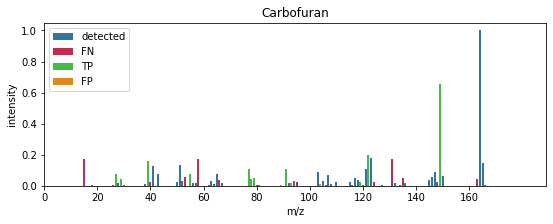

13768 0


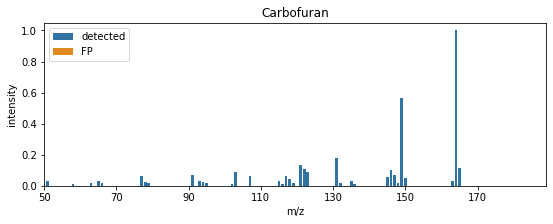

13768 0.05


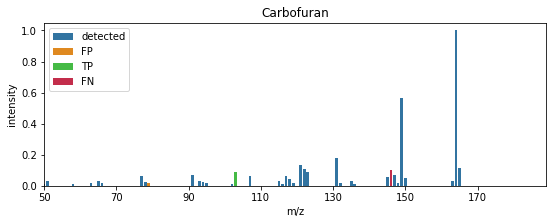

13768 0.1


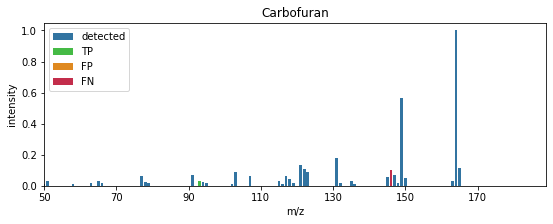

13768 0.15


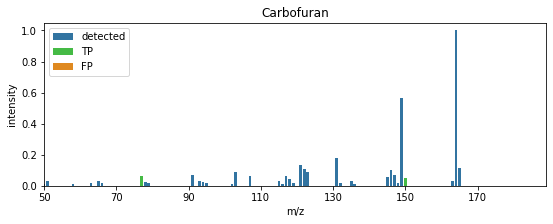

13768 0.2


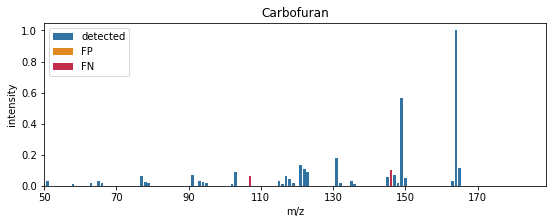

13768 0.25


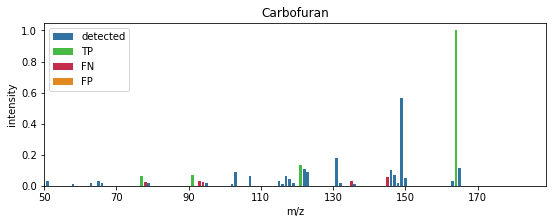

13768 0.3


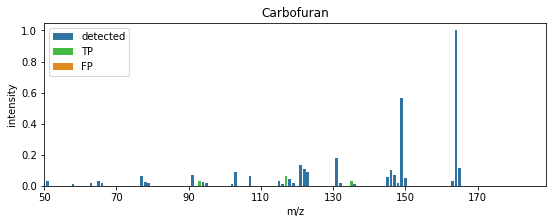

13768 0.35


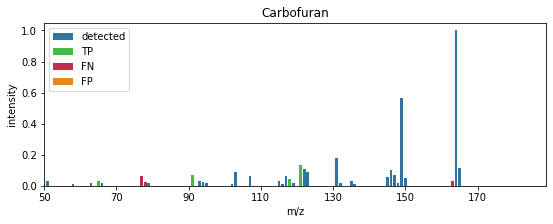

13768 0.4


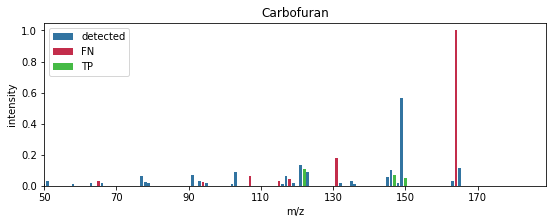

13768 0.45


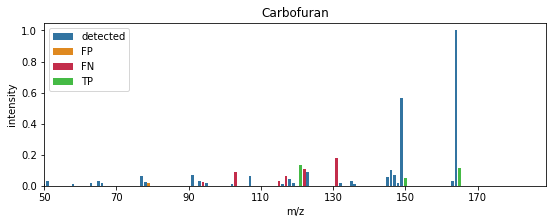

13768 0.5


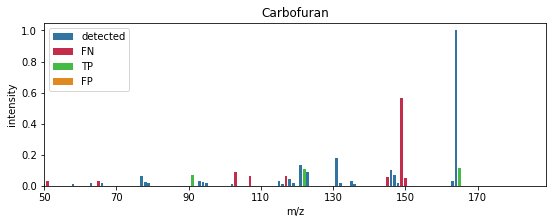

14046 0


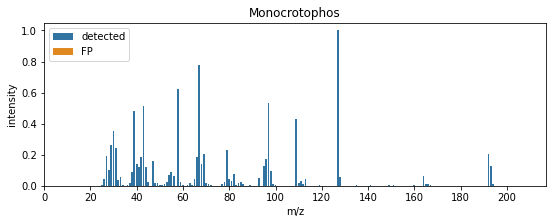

14046 0.05


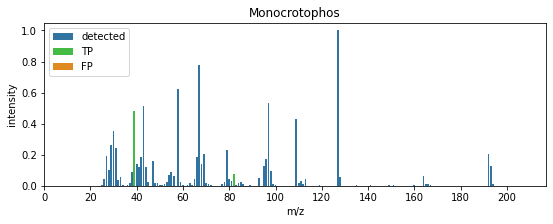

14046 0.1


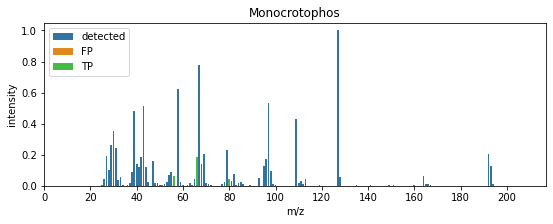

14046 0.15


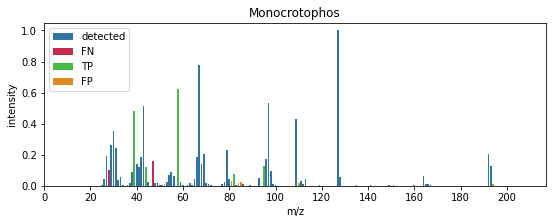

14046 0.2


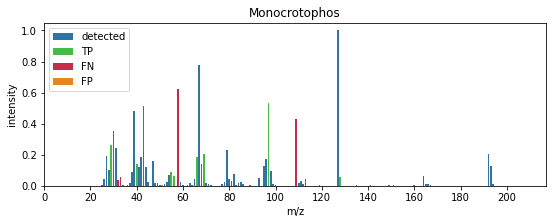

14046 0.25


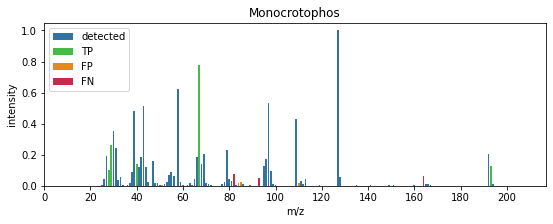

14046 0.3


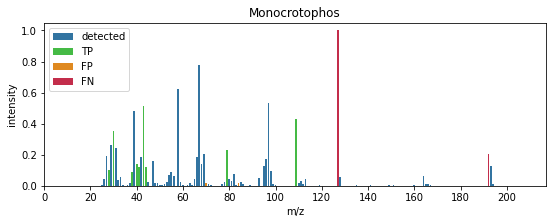

14046 0.35


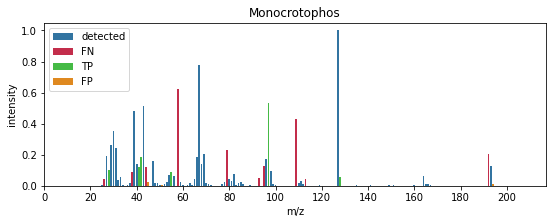

14046 0.4


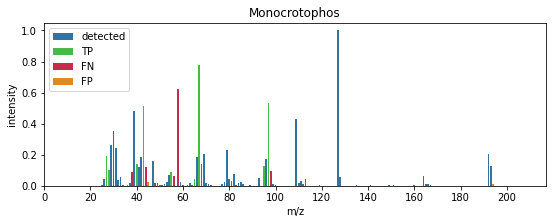

14046 0.45


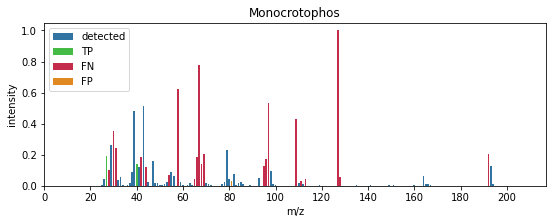

14046 0.5


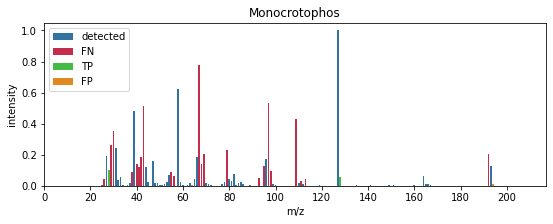

14047 0


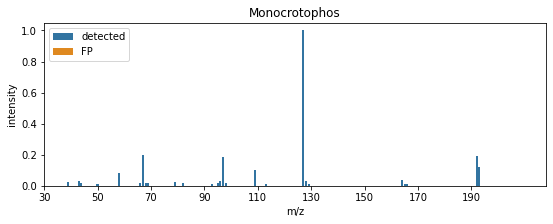

14047 0.05


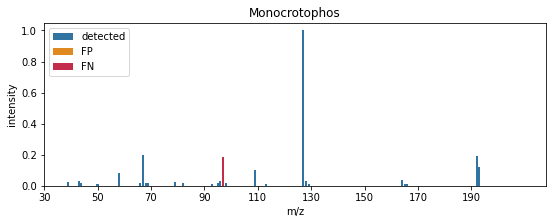

14047 0.1


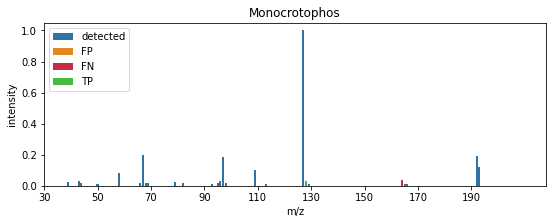

14047 0.15


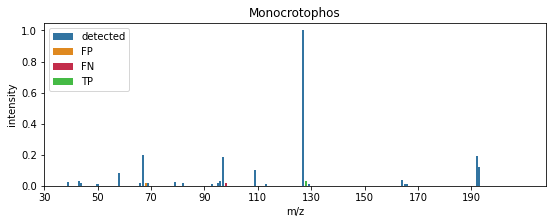

14047 0.2


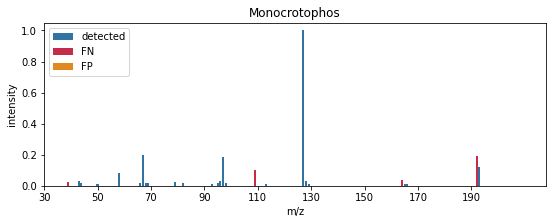

14047 0.25


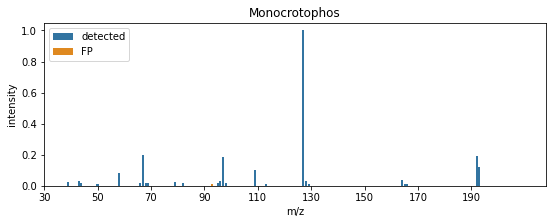

14047 0.3


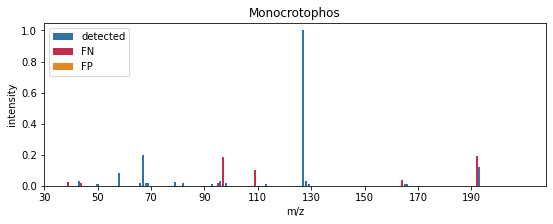

14047 0.35


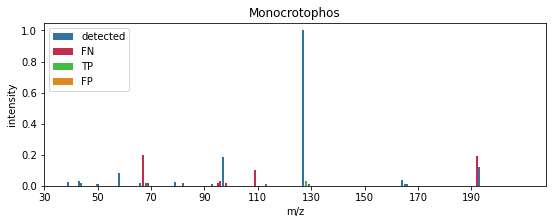

14047 0.4


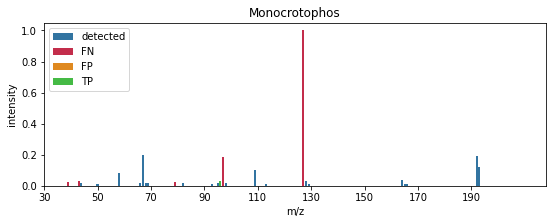

14047 0.45


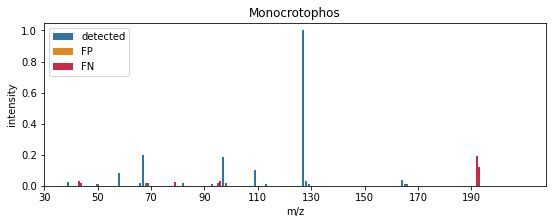

14047 0.5


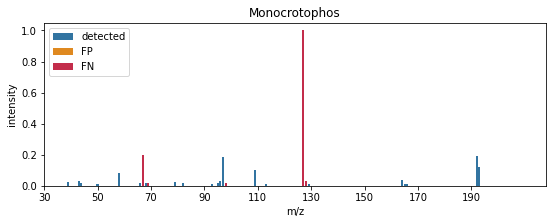

14149 0


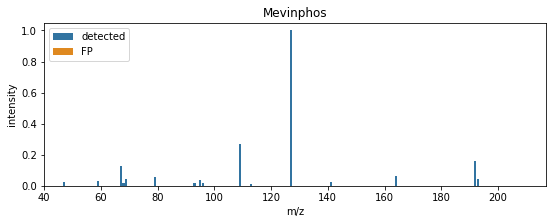

14149 0.05


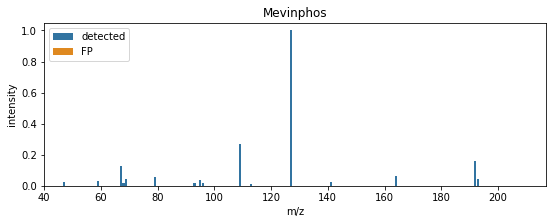

14149 0.1


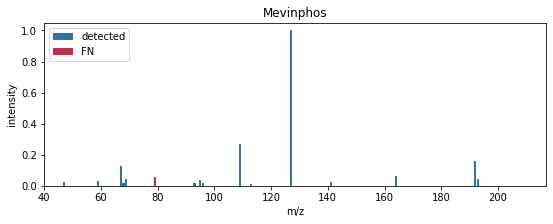

14149 0.15


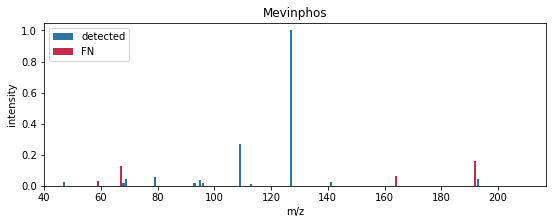

14149 0.2


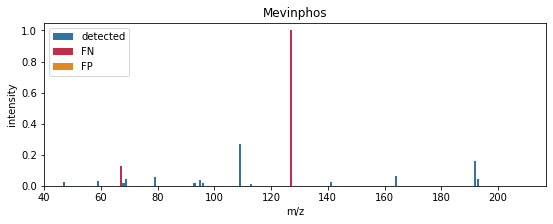

14149 0.25


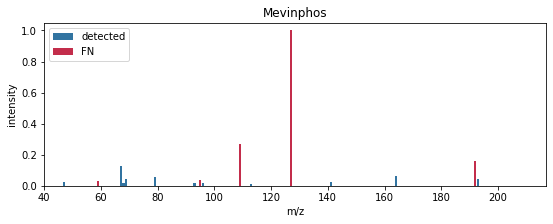

14149 0.3


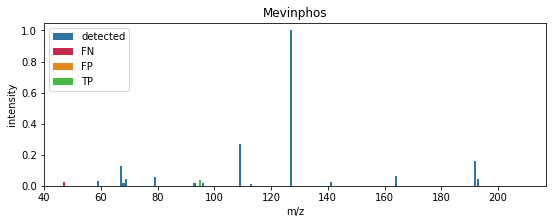

14149 0.35


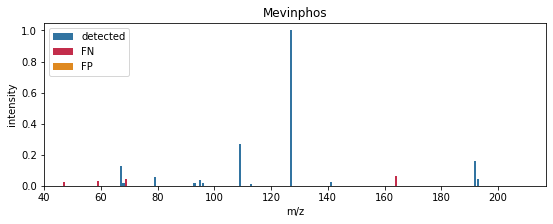

14149 0.4


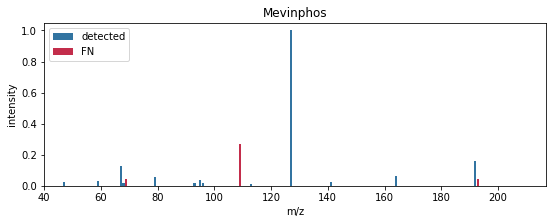

14149 0.45


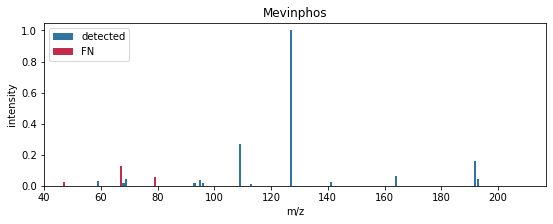

14149 0.5


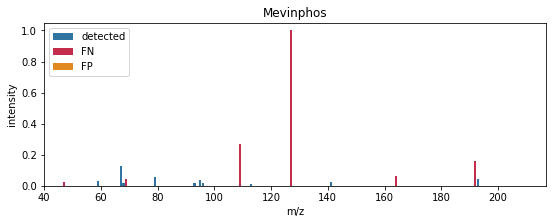

14150 0


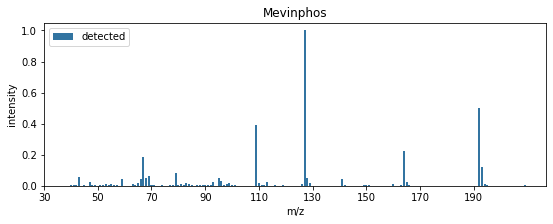

14150 0.05


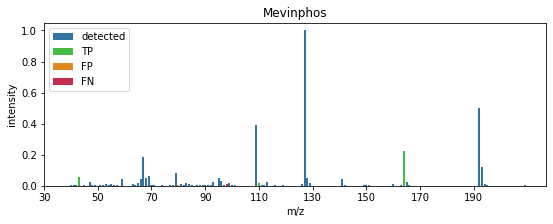

14150 0.1


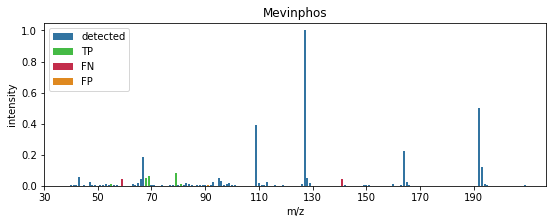

14150 0.15


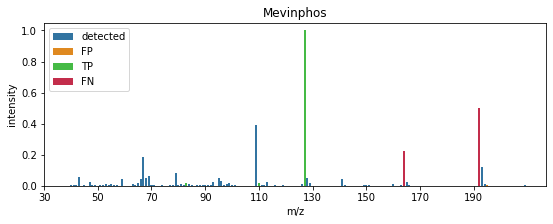

14150 0.2


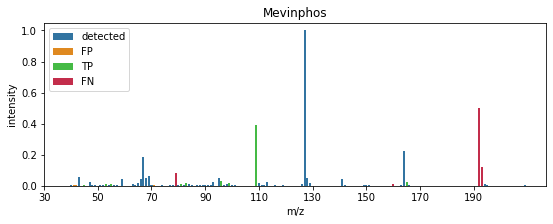

14150 0.25


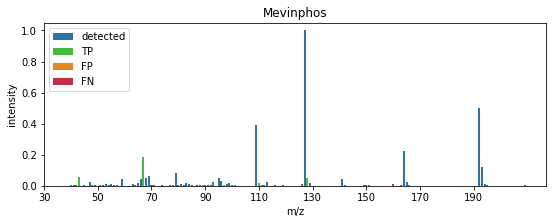

14150 0.3


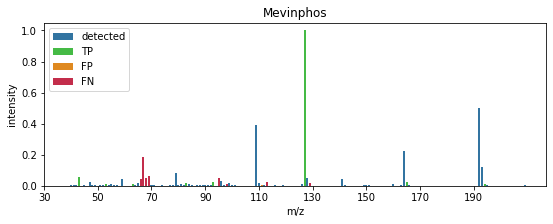

14150 0.35


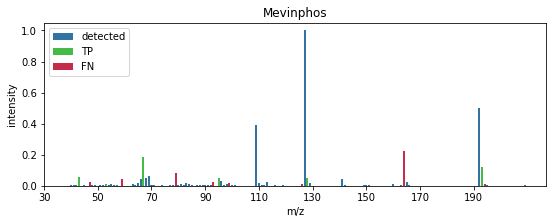

14150 0.4


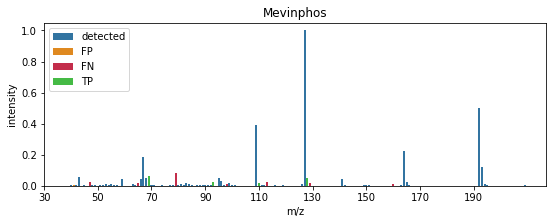

14150 0.45


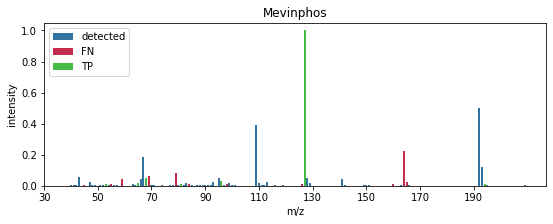

14150 0.5


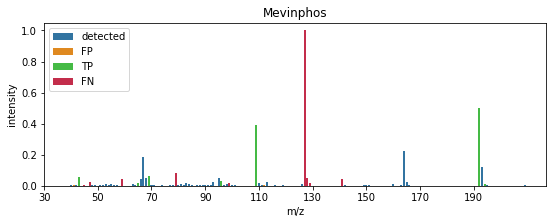

17961 0


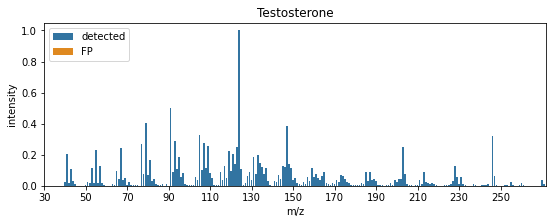

17961 0.05


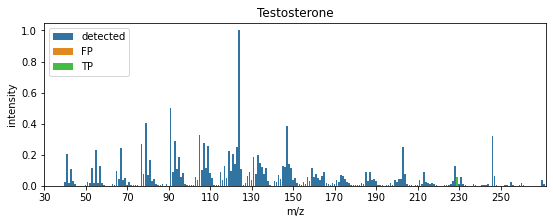

17961 0.1


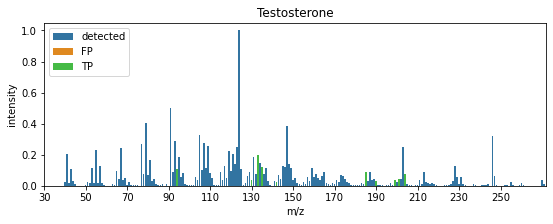

17961 0.15


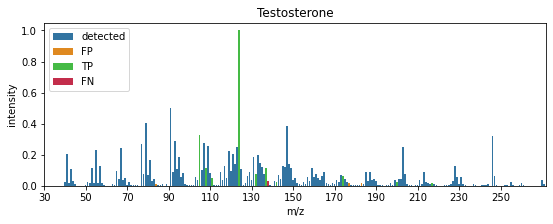

17961 0.2


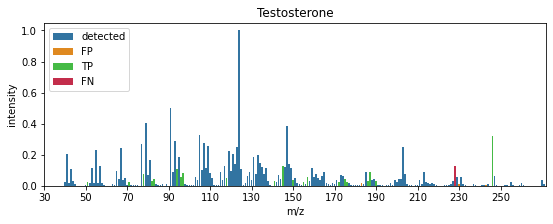

17961 0.25


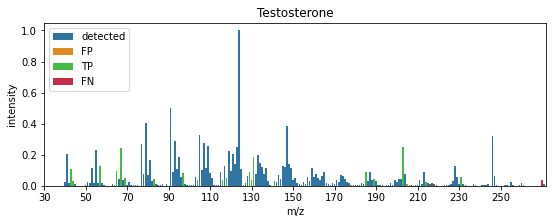

17961 0.3


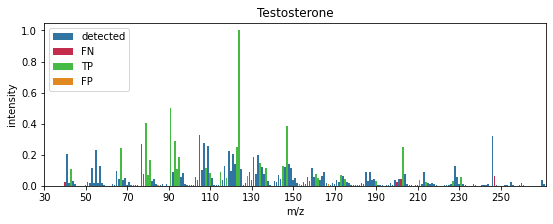

17961 0.35


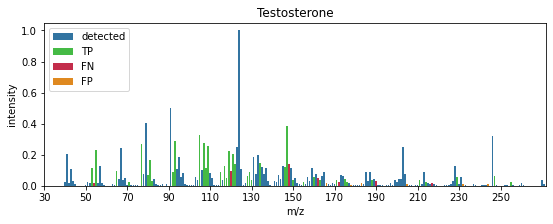

17961 0.4


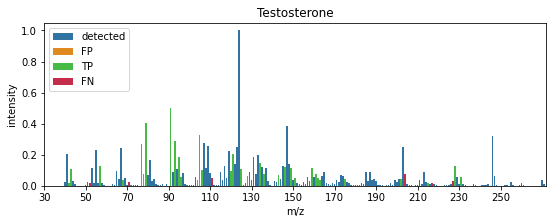

17961 0.45


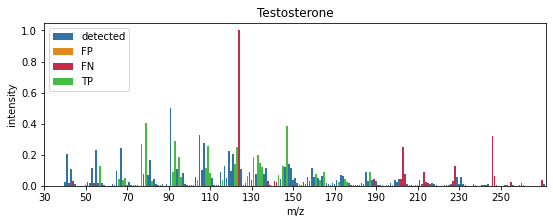

17961 0.5


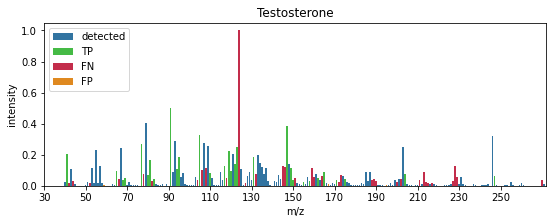

17962 0


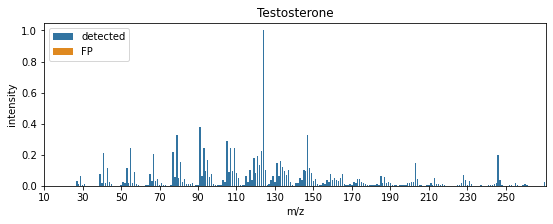

17962 0.05


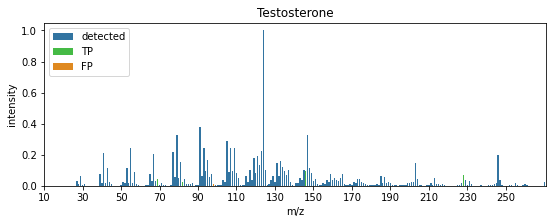

17962 0.1


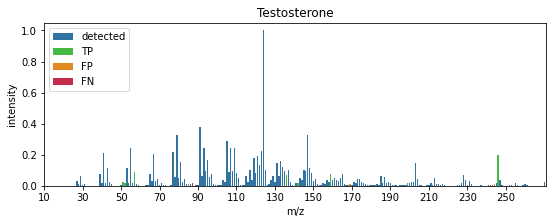

17962 0.15


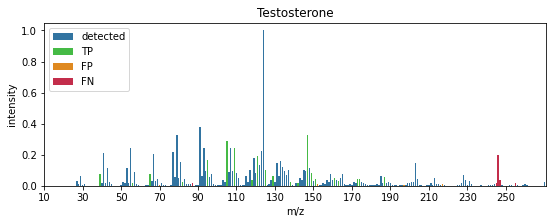

17962 0.2


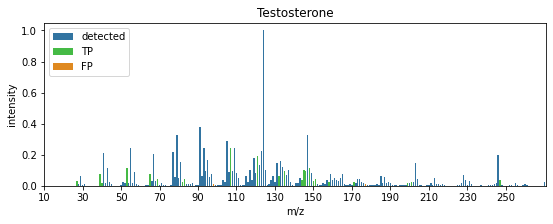

17962 0.25


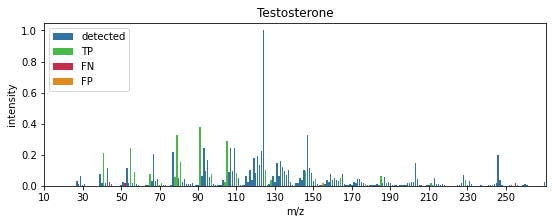

17962 0.3


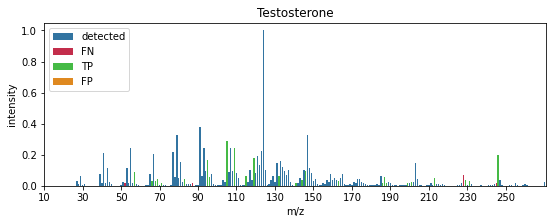

17962 0.35


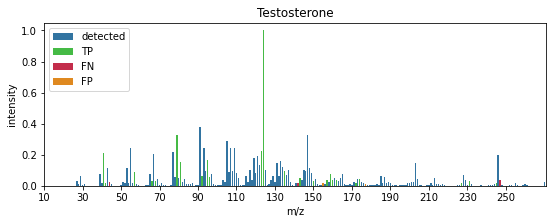

17962 0.4


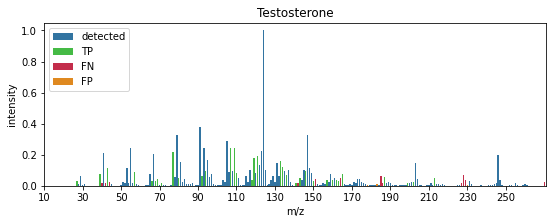

17962 0.45


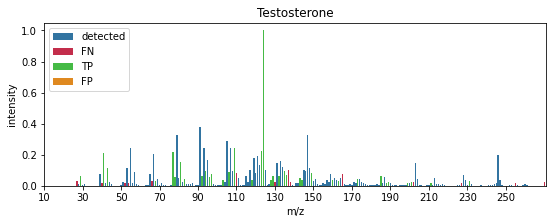

17962 0.5


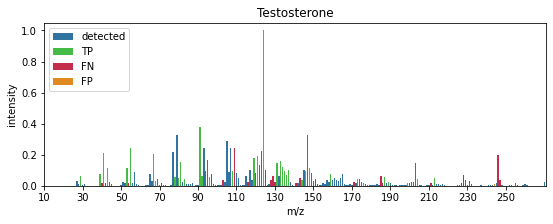

17963 0


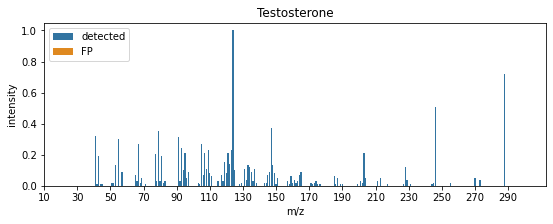

17963 0.05


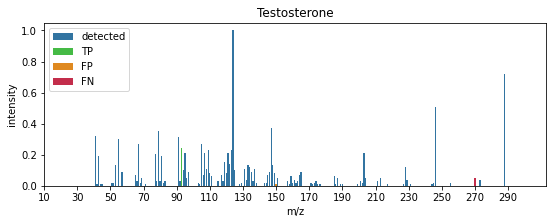

17963 0.1


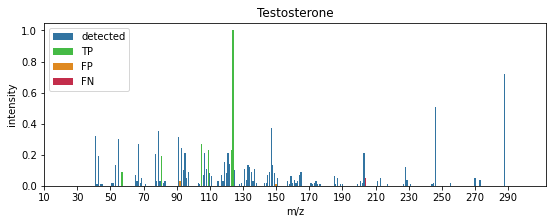

17963 0.15


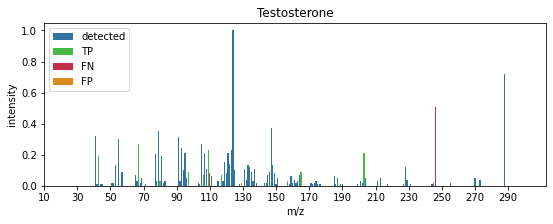

17963 0.2


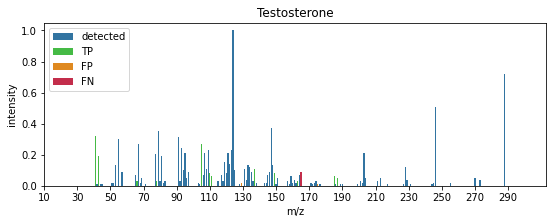

17963 0.25


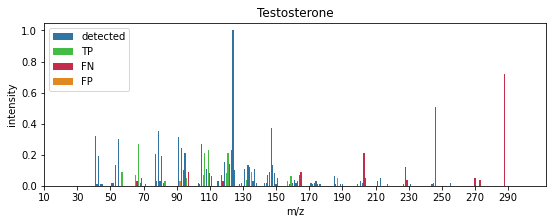

17963 0.3


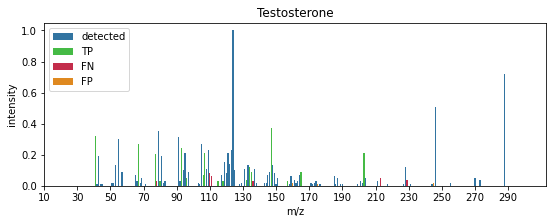

17963 0.35


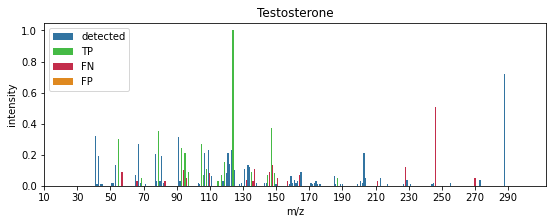

17963 0.4


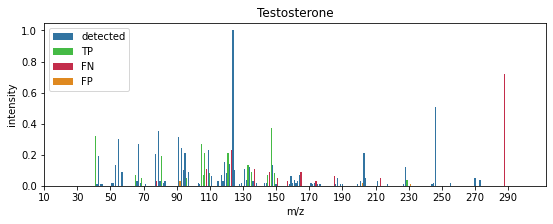

17963 0.45


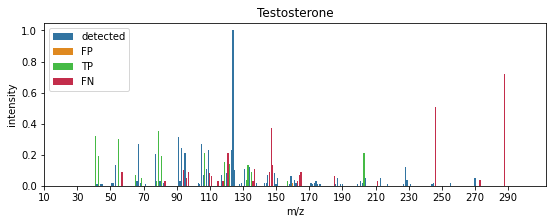

17963 0.5


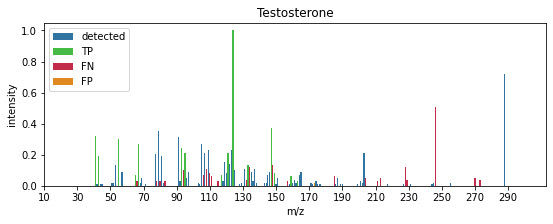

17964 0


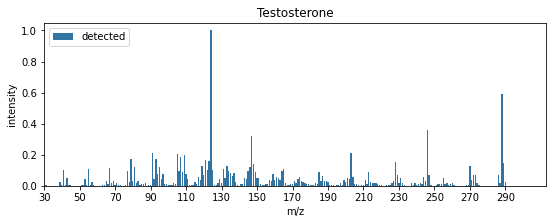

17964 0.05


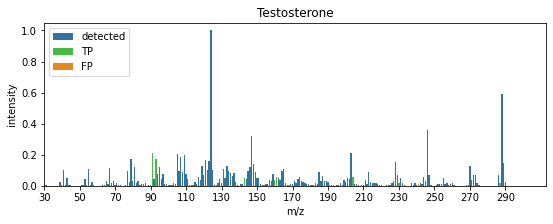

17964 0.1


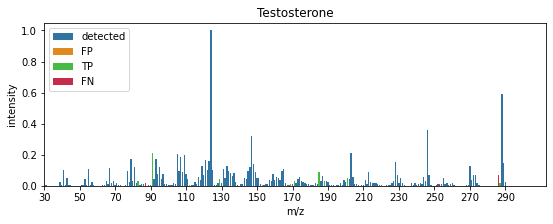

17964 0.15


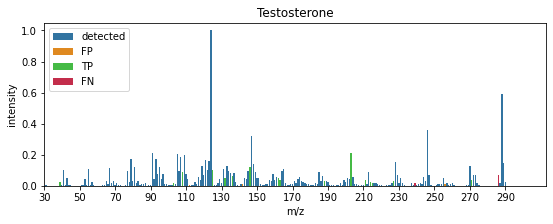

17964 0.2


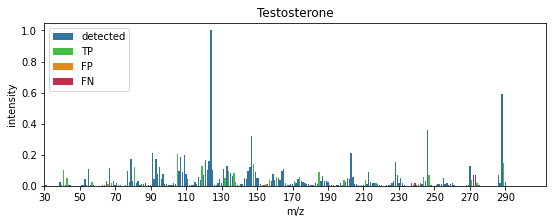

17964 0.25


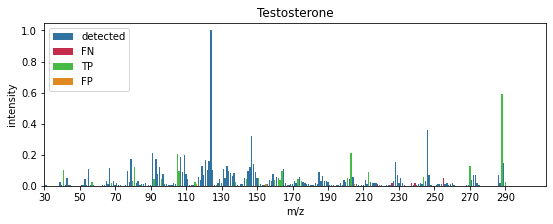

17964 0.3


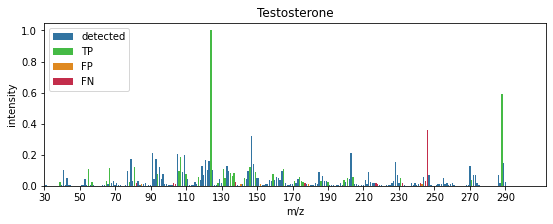

17964 0.35


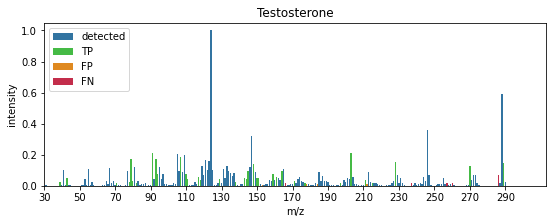

17964 0.4


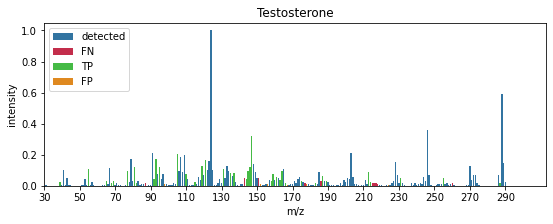

17964 0.45


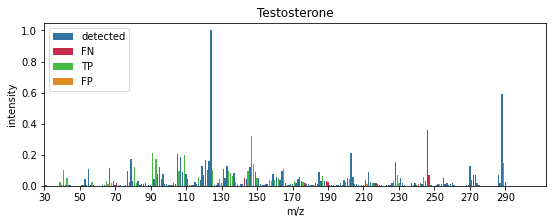

17964 0.5


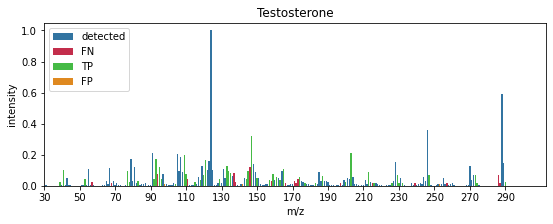

17965 0


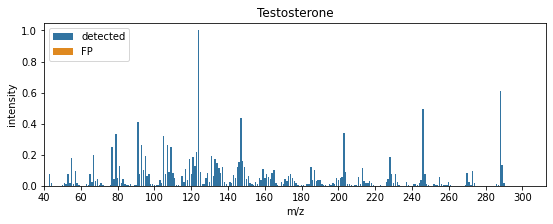

17965 0.05


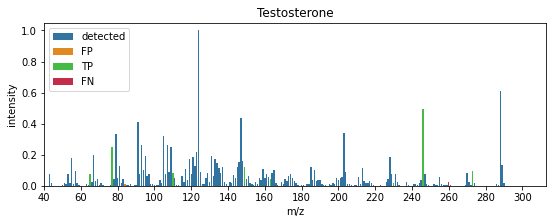

17965 0.1


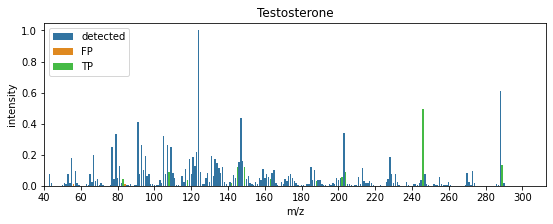

17965 0.15


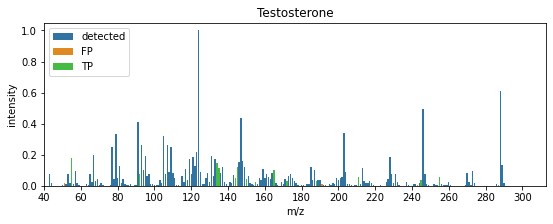

17965 0.2


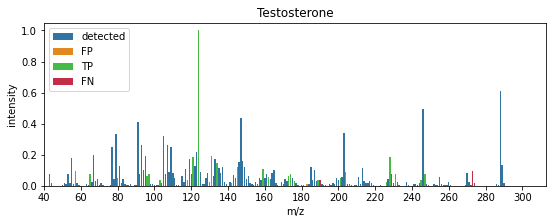

17965 0.25


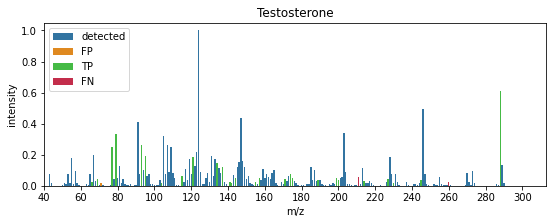

17965 0.3


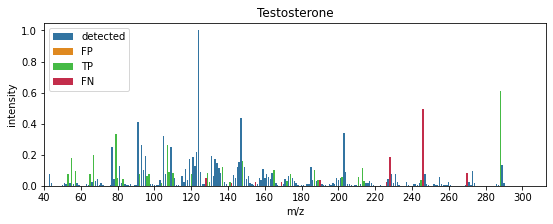

17965 0.35


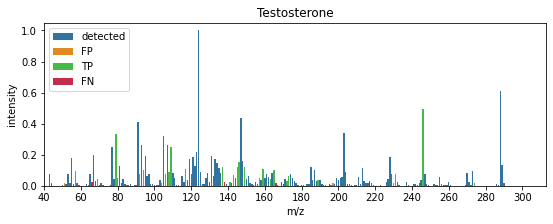

17965 0.4


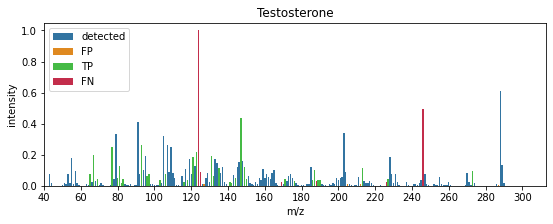

17965 0.45


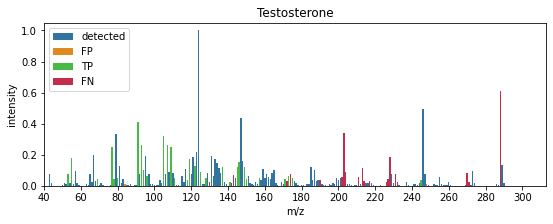

17965 0.5


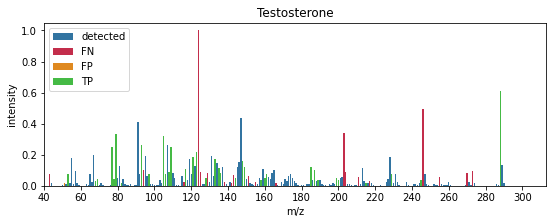

In [40]:
interesting =  ["Atrazine", "Carbofuran", "Monocrotophos", "Mevinphos", "Testosterone"]
for i in range(len(datasets_indb["spec_test"])):
    if datasets_indb["spec_test"][i].metadata["name"] in interesting:
        for k in range(len(probs)):
            print(i,probs[k])
            #plot_beauty(datasets_indb["spec_test"], i, k, preds, ys, i2e)
            plot_beauty(datasets_indb["fixed_test"].spectrums, i, k, preds, ys, i2e, kind="in_database", kw="mlp", topk=False)

## de novo


In [ ]:
i2e = w2v_dn.wv.index2entity
_, scores_gpt = model_selection("predictions/de_novo", "hugg_test", kw="gpt2_h6l6_auto", up_to_k=30, \
                                      l=4, j=6, to_rel_inten=.2, l_rel=None, return_details=True)

In [60]:
preds, ys = scores_gpt["gpt2_h6l6_auto"]["dets"]["all"].values()

12701 3


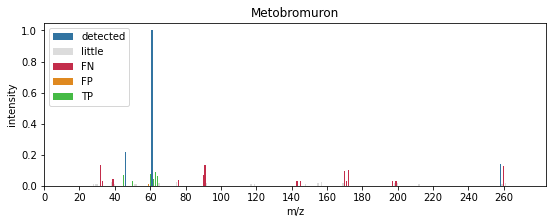

12701 4


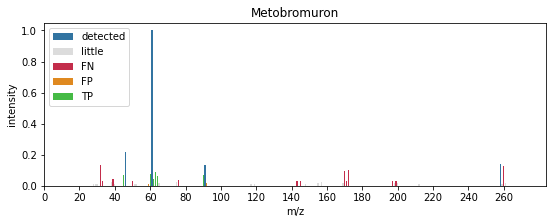

12701 5


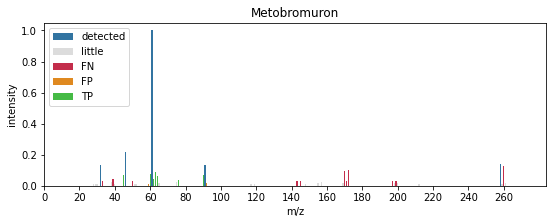

12701 6


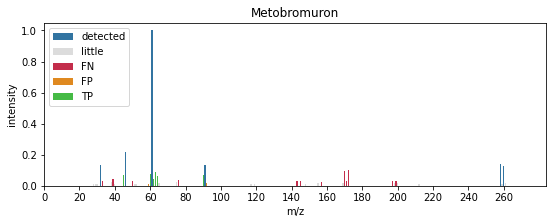

12701 7


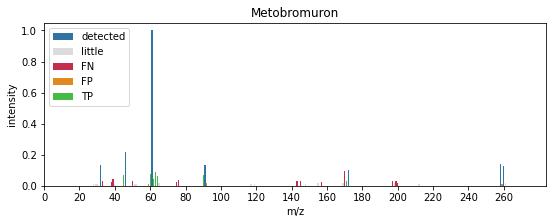

12702 3


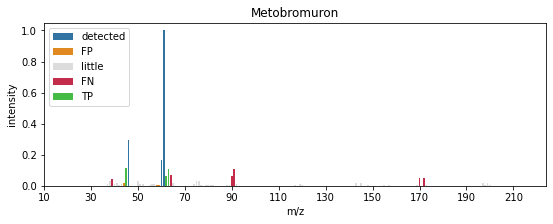

12702 4


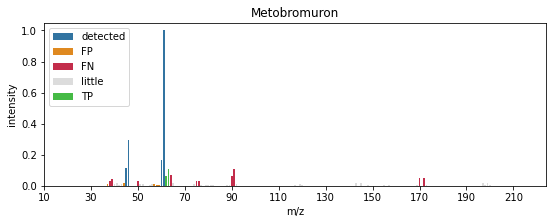

12702 5


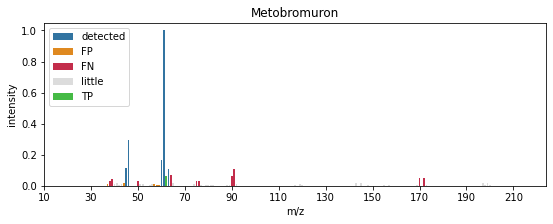

12702 6


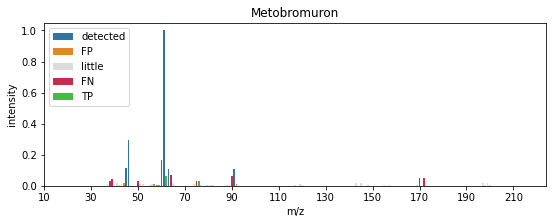

12702 7


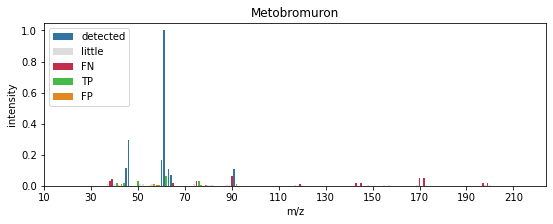

12703 3


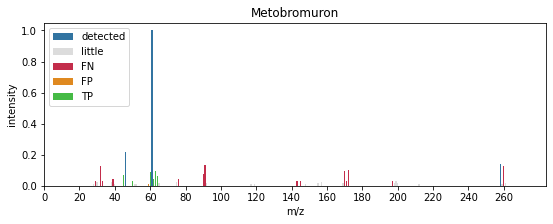

12703 4


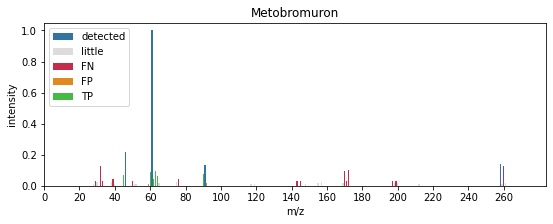

12703 5


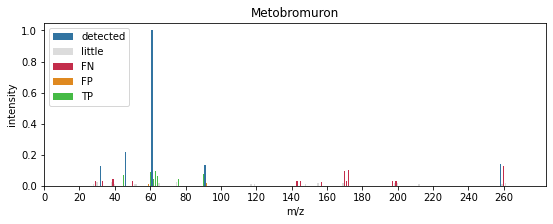

12703 6


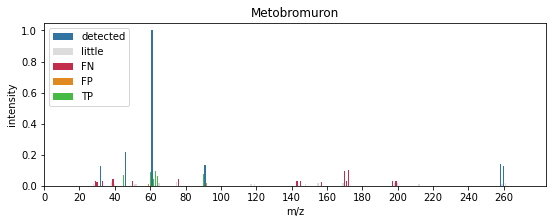

12703 7


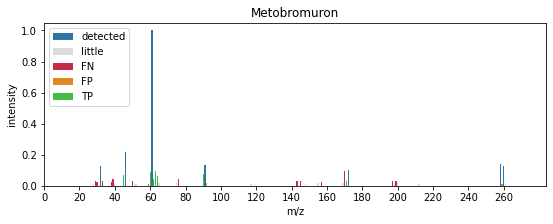

22461 3


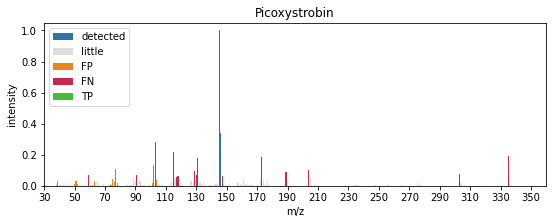

22461 4


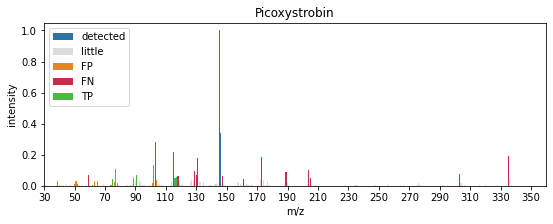

22461 5


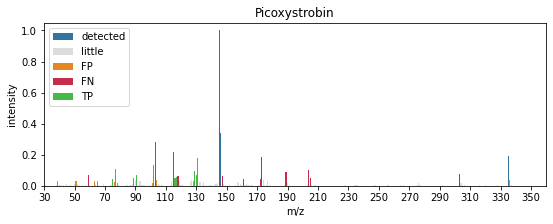

22461 6


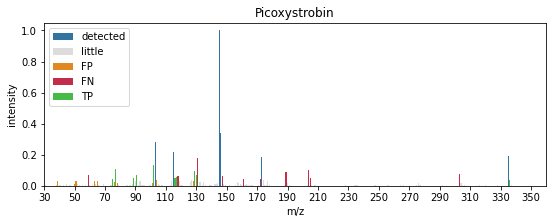

22461 7


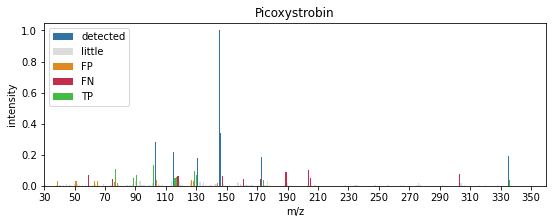

22462 3


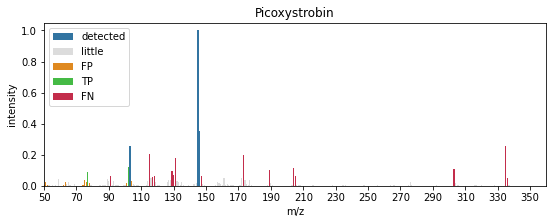

22462 4


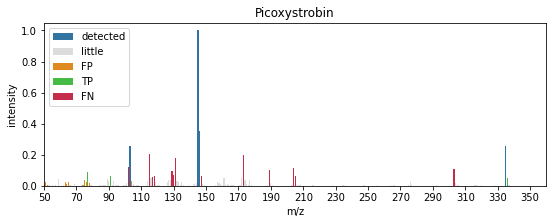

22462 5


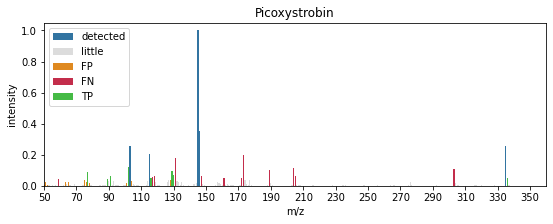

22462 6


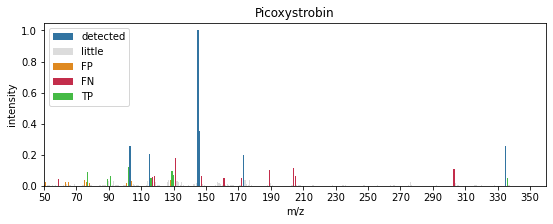

22462 7


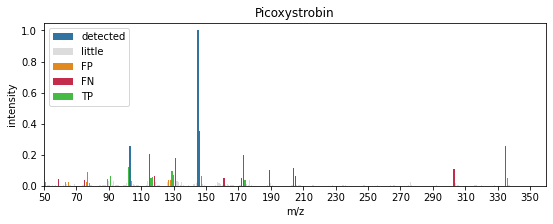

22463 3


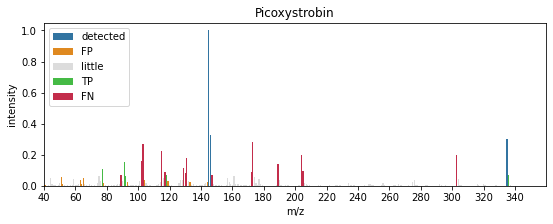

22463 4


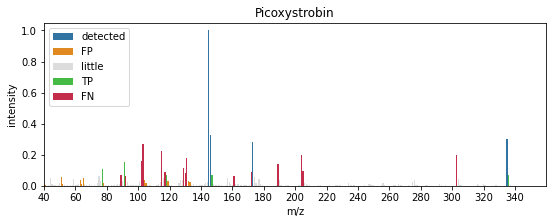

22463 5


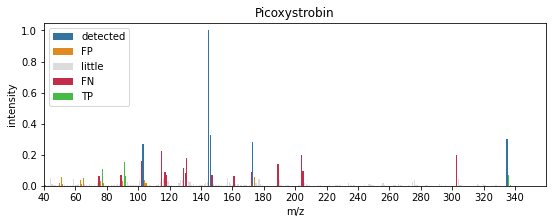

22463 6


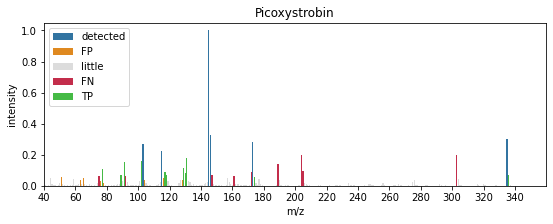

22463 7


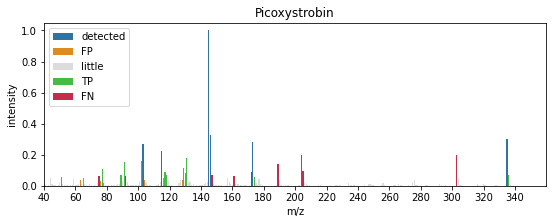

22464 3


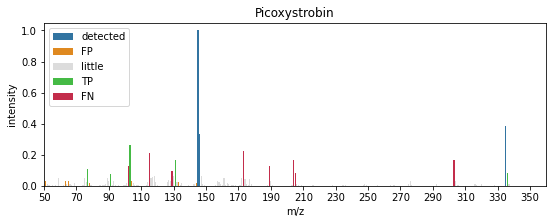

22464 4


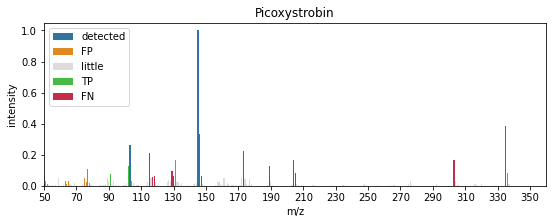

22464 5


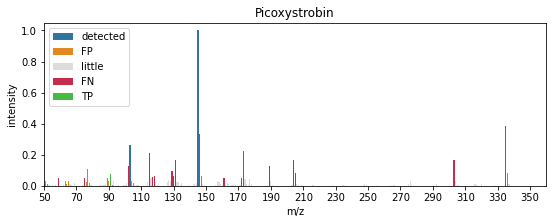

22464 6


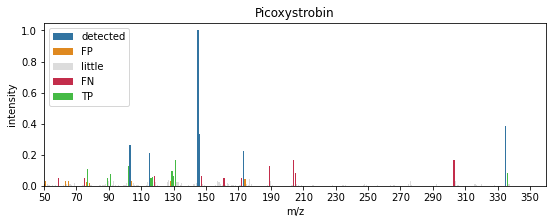

22464 7


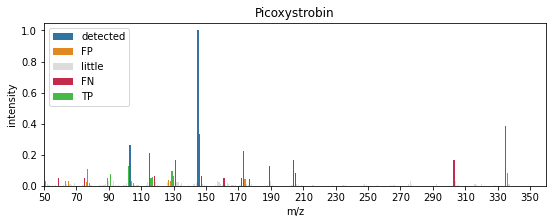

23073 3


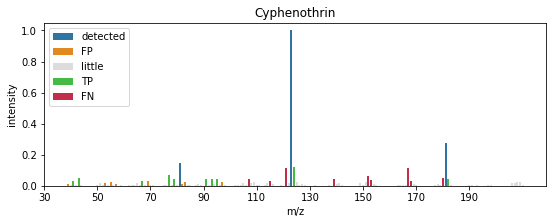

23073 4


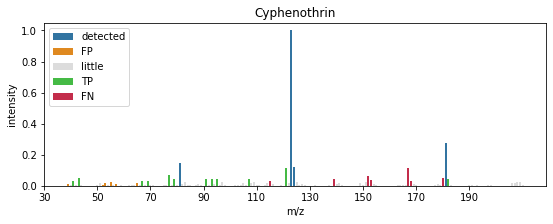

23073 5


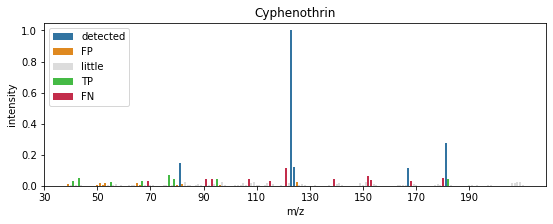

23073 6


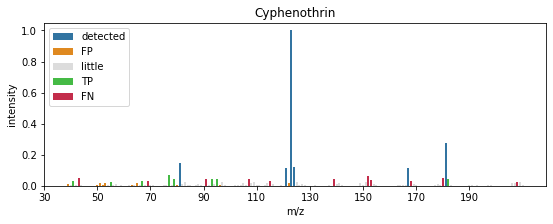

23073 7


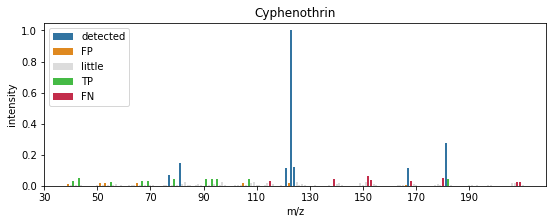

27346 3


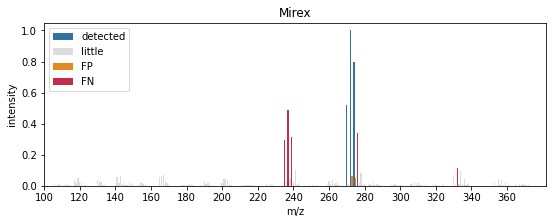

27346 4


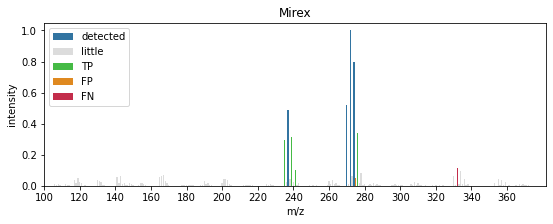

27346 5


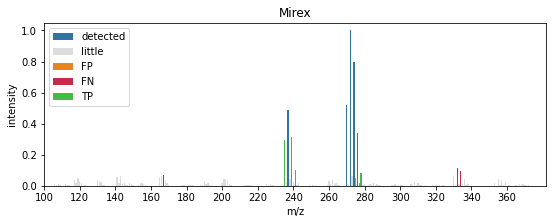

27346 6


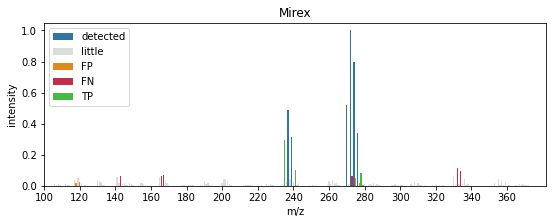

27346 7


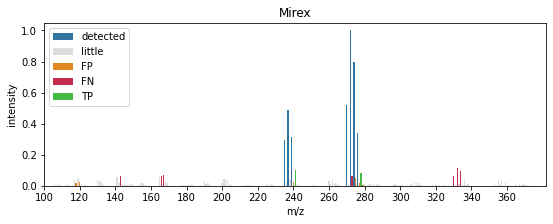

27347 3


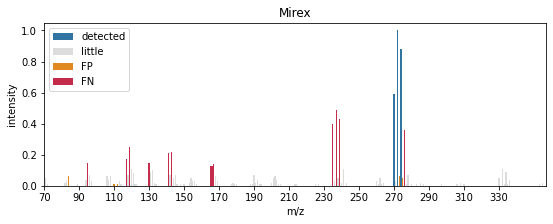

27347 4


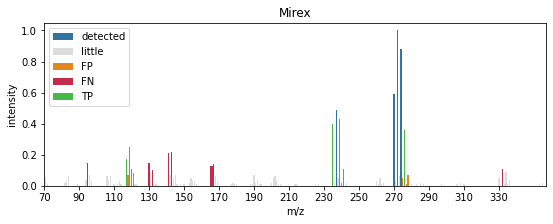

27347 5


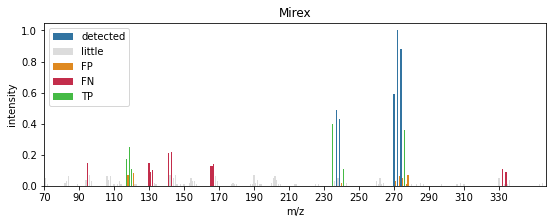

27347 6


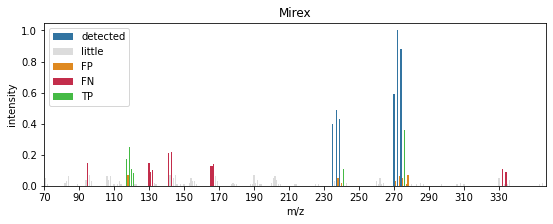

27347 7


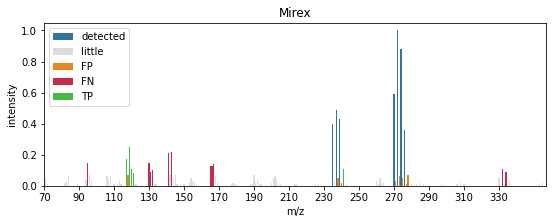

27348 3


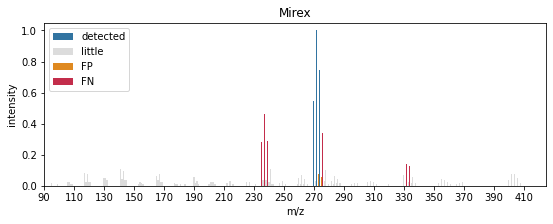

27348 4


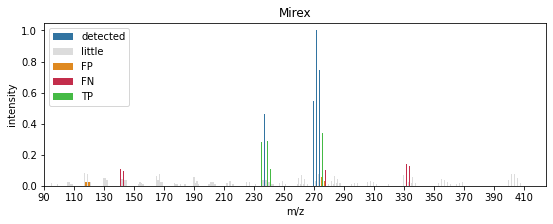

27348 5


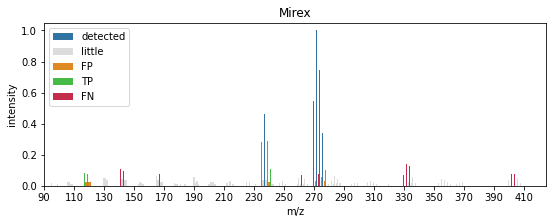

27348 6


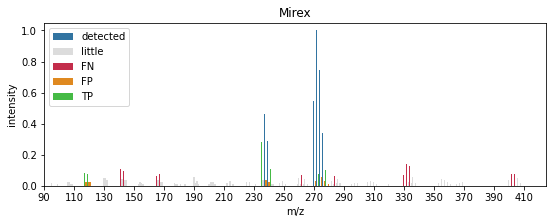

27348 7


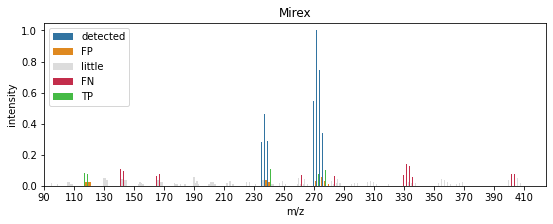

27349 3


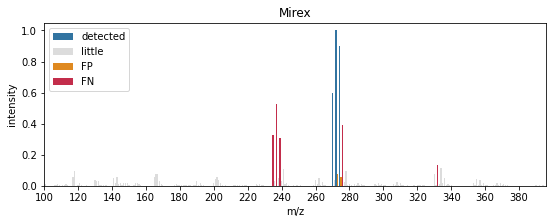

27349 4


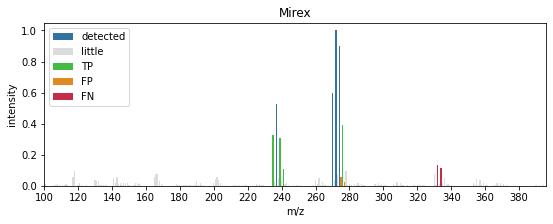

27349 5


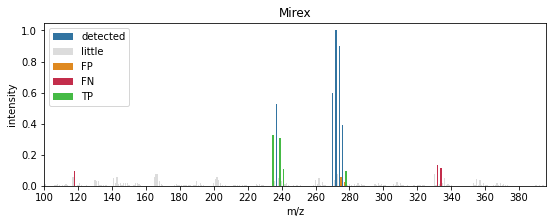

27349 6


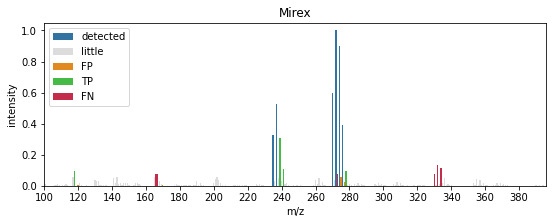

27349 7


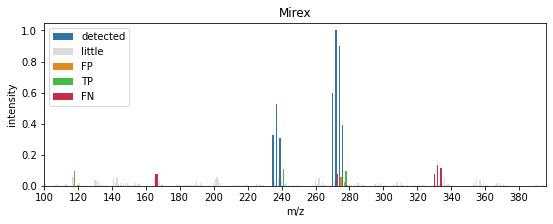

In [65]:
interesting =  ["Metobromuron", "Picoxystrobin", "Cyphenothrin", "Mirex"]
for i in range(len(datasets_denovo["spec_test"])):
    if datasets_denovo["spec_test"][i].metadata["name"] in interesting:
        for k in [3,4,5,6,7]:
            print(i,k)
            plot_beauty(datasets_denovo["spec_test"], i, k, preds, ys, i2e)

In [72]:
i2e = w2v_dn.wv.index2entity
_, scores_mlp = model_selection_random("predictions/de_novo", "fixed_test", kw="mlp", return_details=True)

mlp_3_.3


/auto/brno6/home/xstary1/raims/metrics.py:232: RuntimeWarning: Mean of empty slice
  "mp": np.nanmean(recs_some, axis=1),
/auto/brno6/home/xstary1/raims/metrics.py:234: RuntimeWarning: Mean of empty slice
  "mf1": np.nanmean(f1_some, axis=1),
/auto/brno6/home/xstary1/raims/metrics.py:235: RuntimeWarning: Mean of empty slice
  "mps": np.nanmean(precs_m, axis=1)


In [73]:
preds, ys = scores_mlp["mlp_3_.3"]["all"].values()

12701 0


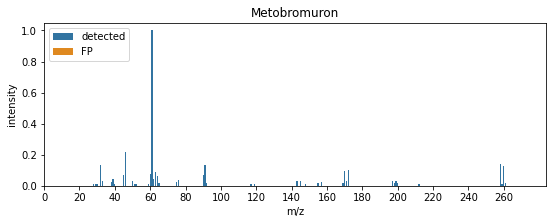

12701 0.05


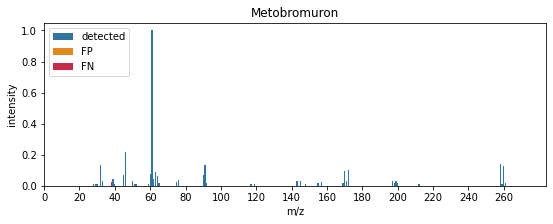

12701 0.1


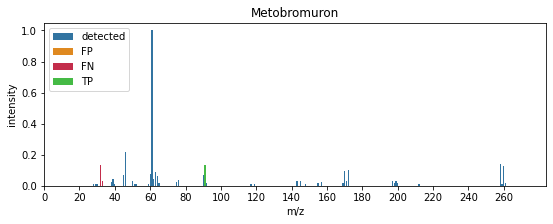

12701 0.15


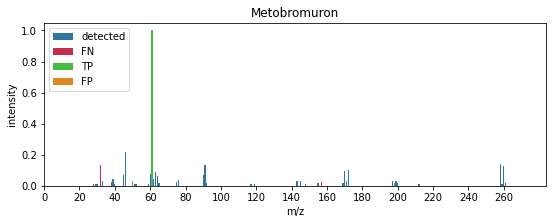

12701 0.2


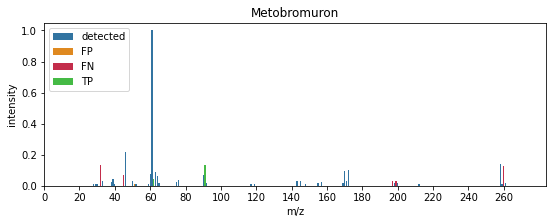

12701 0.25


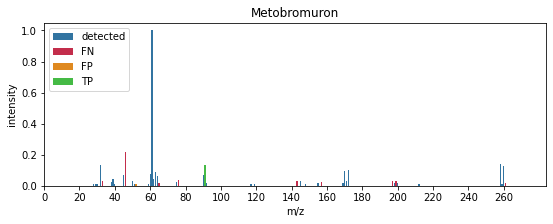

12701 0.3


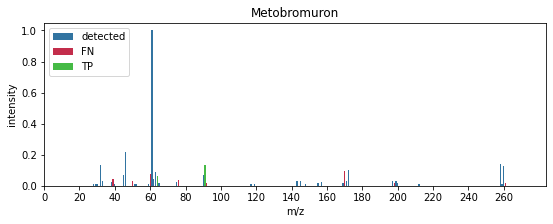

12701 0.35


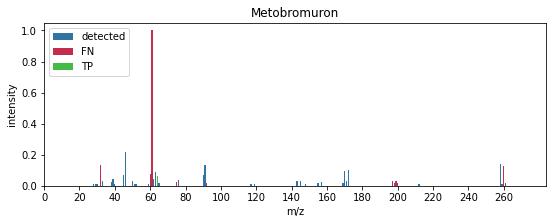

12701 0.4


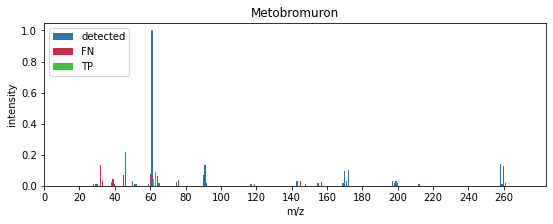

12701 0.45


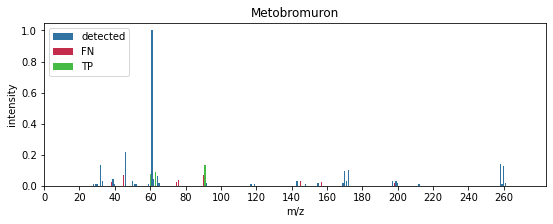

12701 0.5


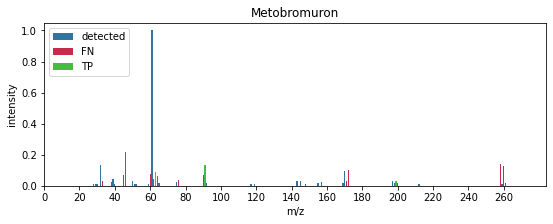

12702 0


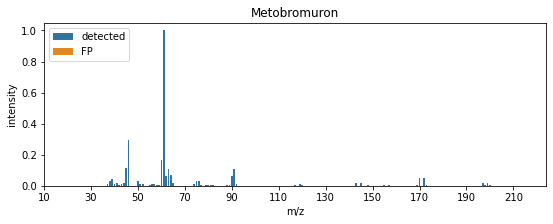

12702 0.05


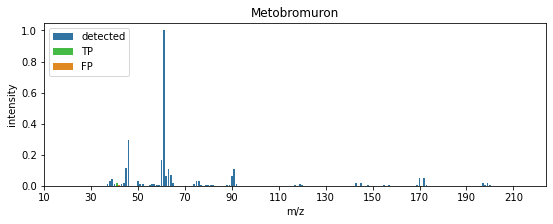

12702 0.1


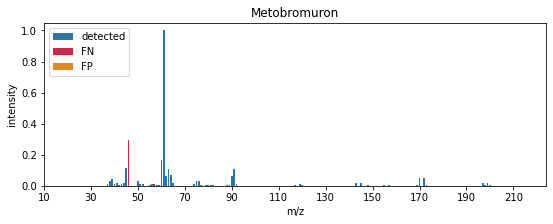

12702 0.15


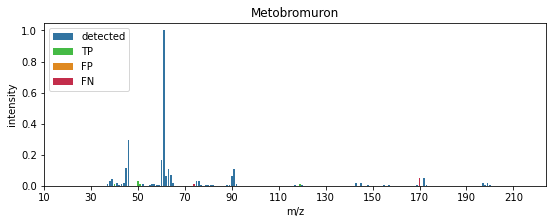

12702 0.2


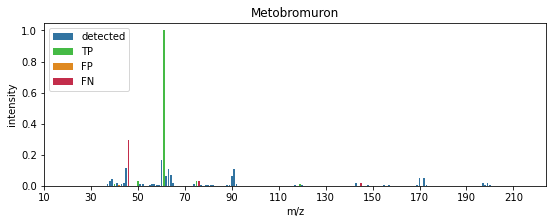

12702 0.25


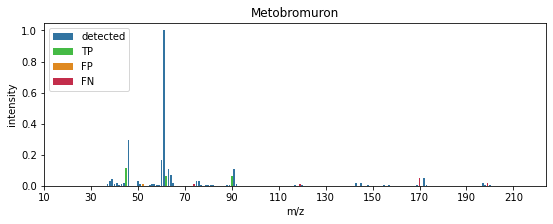

12702 0.3


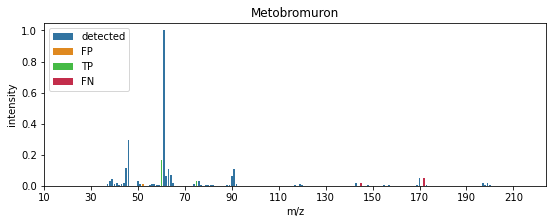

12702 0.35


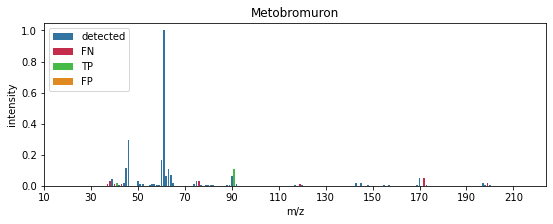

12702 0.4


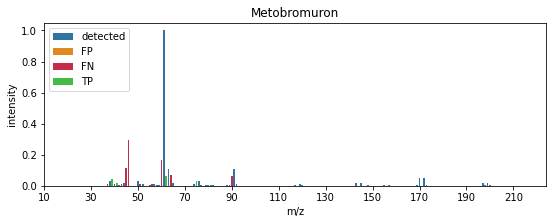

12702 0.45


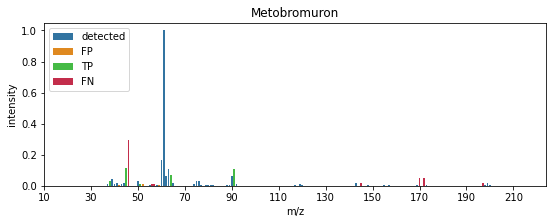

12702 0.5


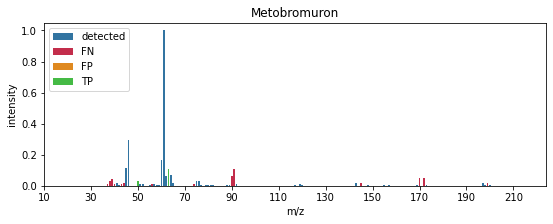

12703 0


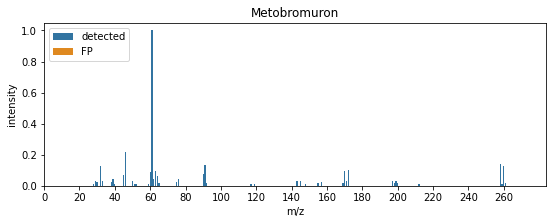

12703 0.05


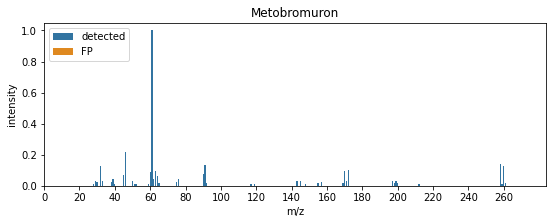

12703 0.1


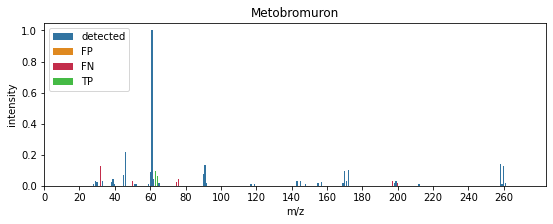

12703 0.15


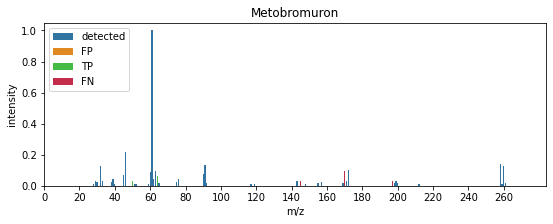

12703 0.2


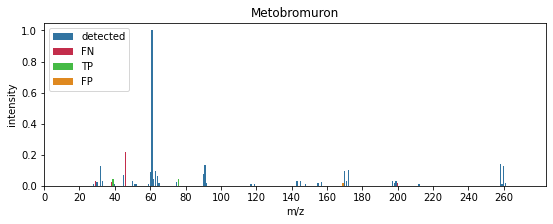

12703 0.25


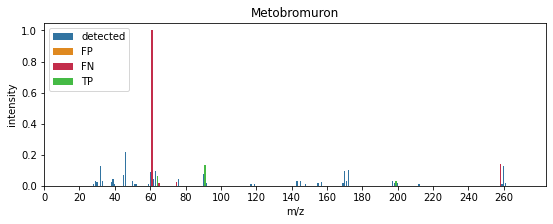

12703 0.3


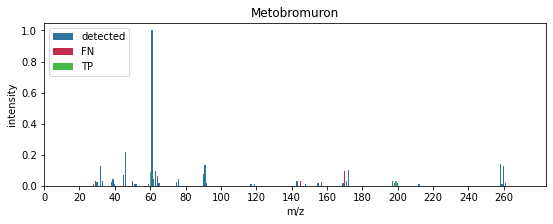

12703 0.35


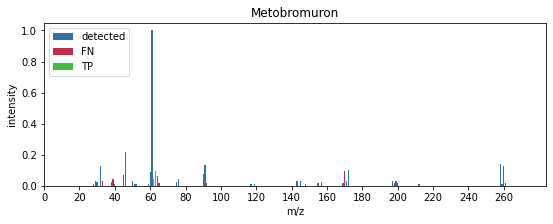

12703 0.4


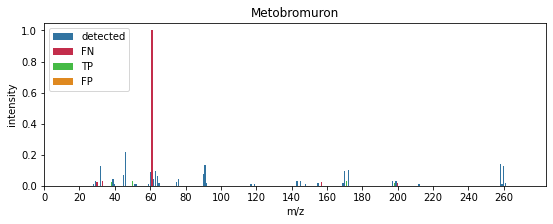

12703 0.45


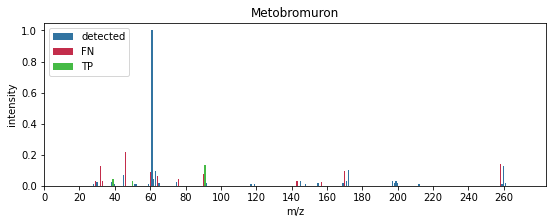

12703 0.5


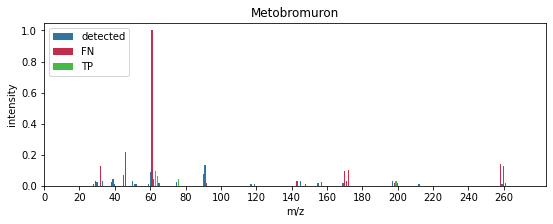

22461 0


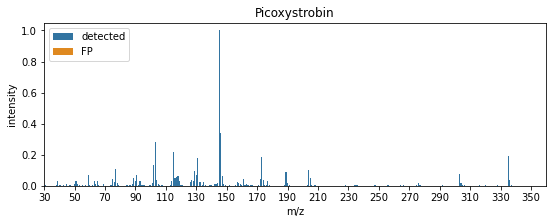

22461 0.05


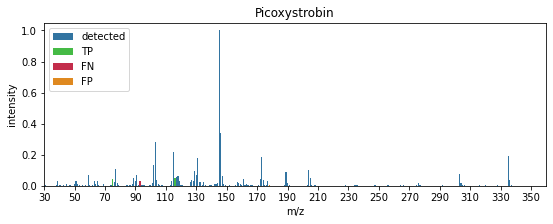

22461 0.1


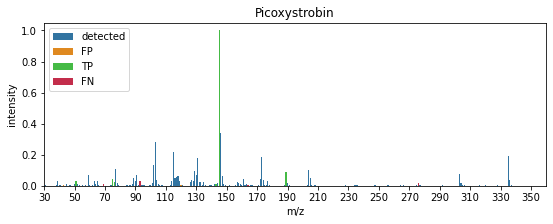

22461 0.15


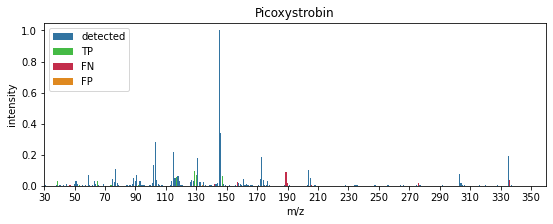

22461 0.2


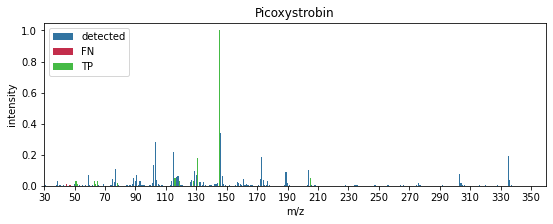

22461 0.25


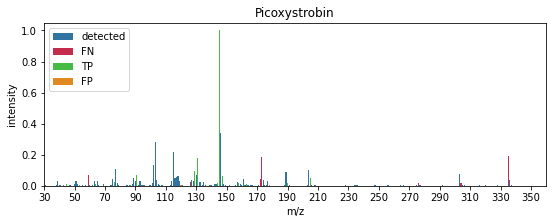

22461 0.3


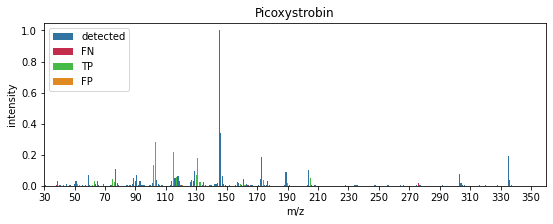

22461 0.35


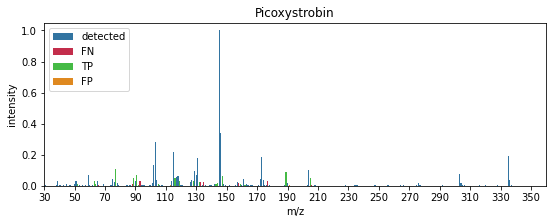

22461 0.4


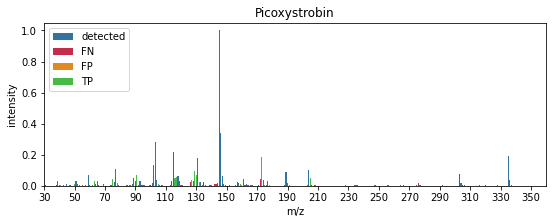

22461 0.45


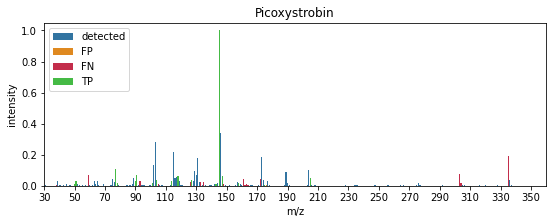

22461 0.5


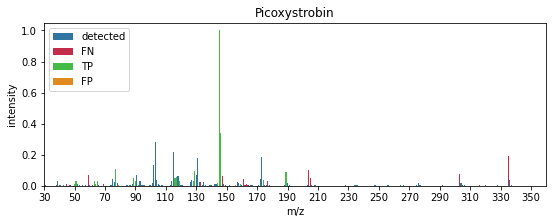

22462 0


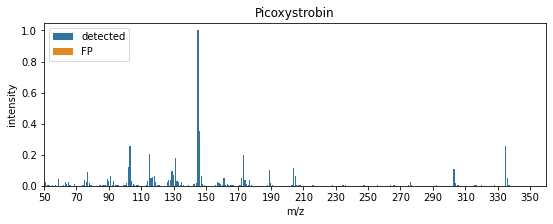

22462 0.05


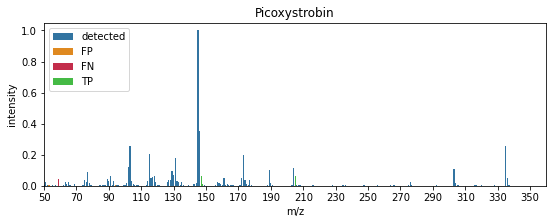

22462 0.1


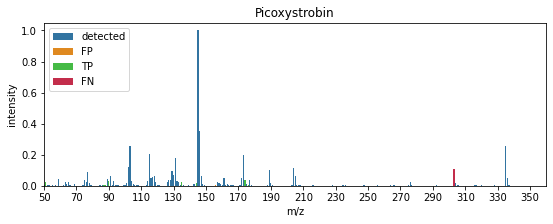

22462 0.15


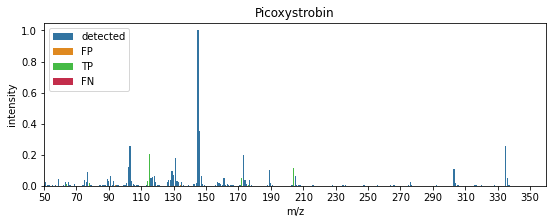

22462 0.2


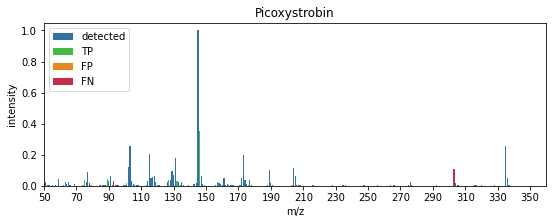

22462 0.25


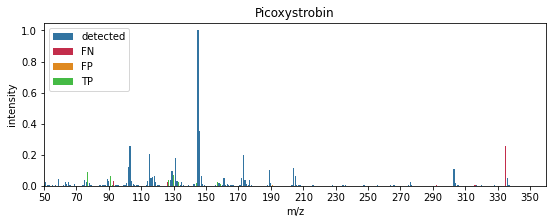

22462 0.3


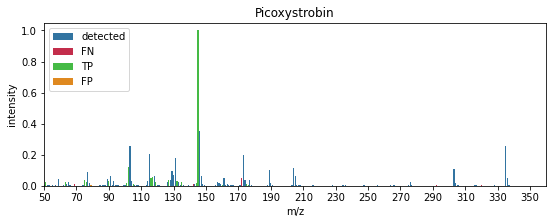

22462 0.35


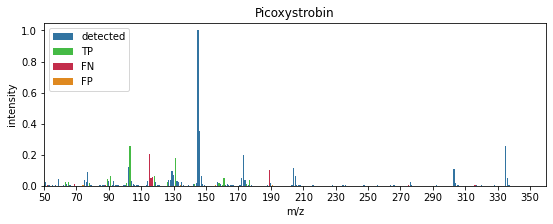

22462 0.4


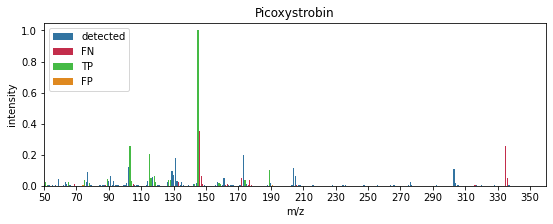

22462 0.45


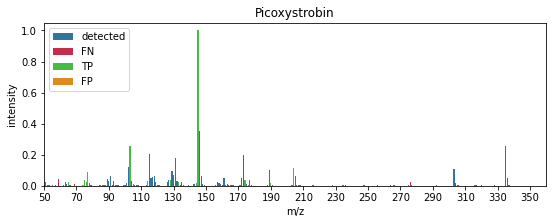

22462 0.5


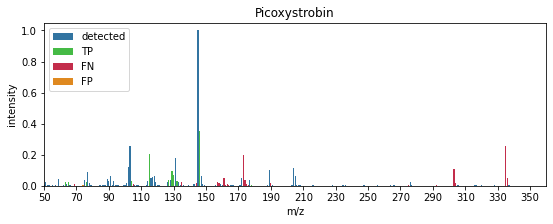

22463 0


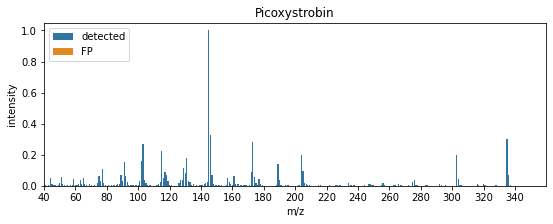

22463 0.05


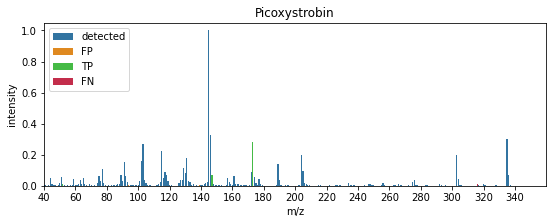

22463 0.1


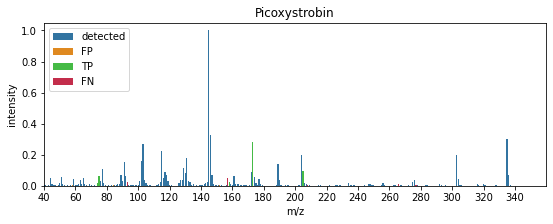

22463 0.15


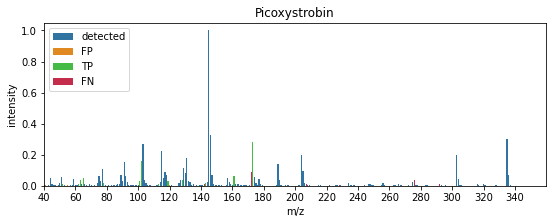

22463 0.2


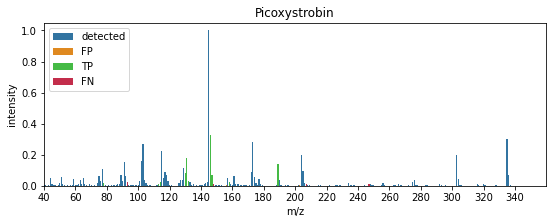

22463 0.25


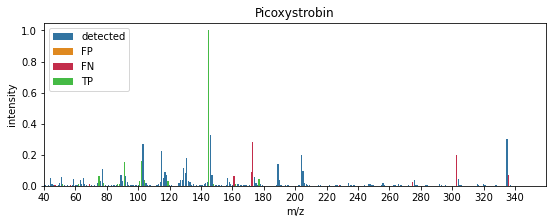

22463 0.3


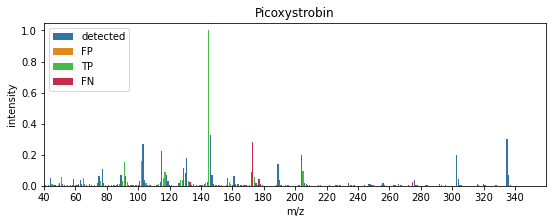

22463 0.35


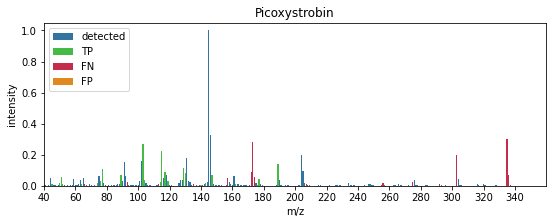

22463 0.4


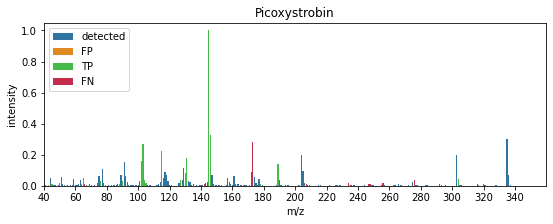

22463 0.45


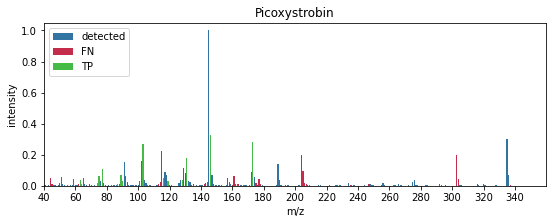

22463 0.5


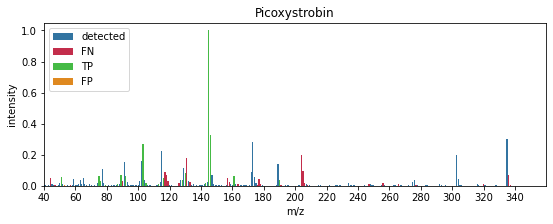

22464 0


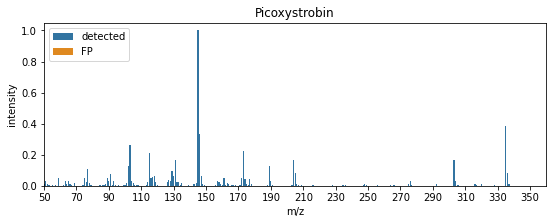

22464 0.05


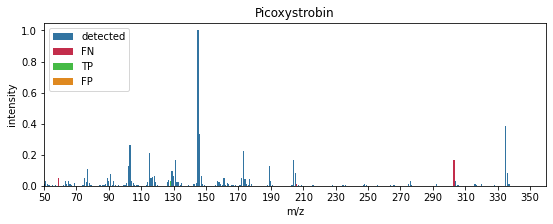

22464 0.1


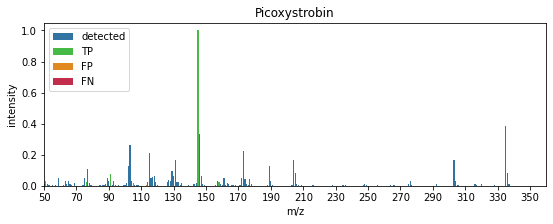

22464 0.15


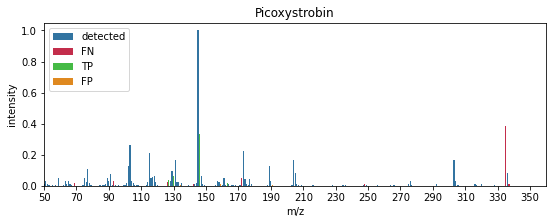

22464 0.2


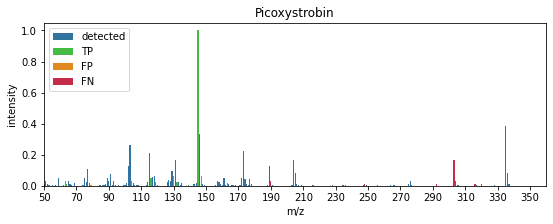

22464 0.25


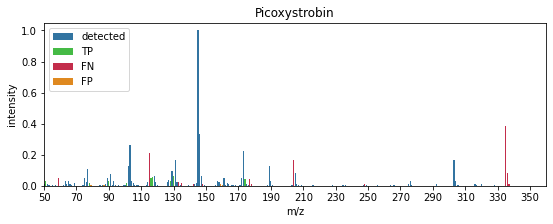

22464 0.3


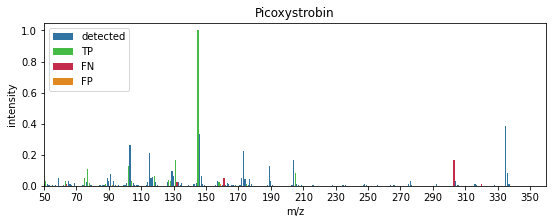

22464 0.35


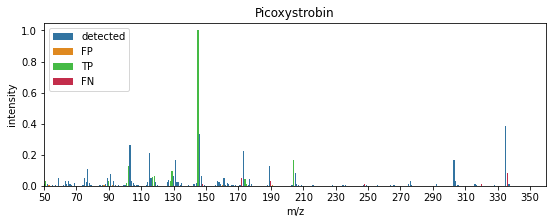

22464 0.4


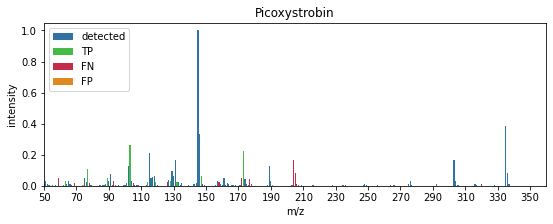

22464 0.45


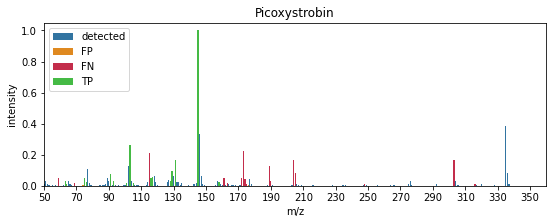

22464 0.5


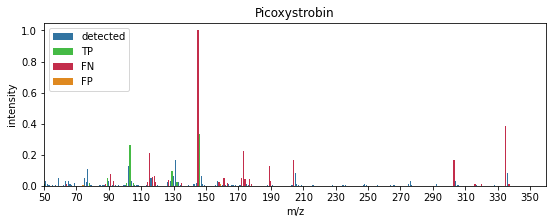

23073 0


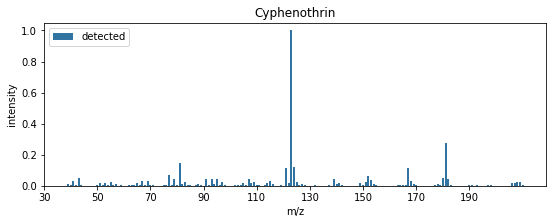

23073 0.05


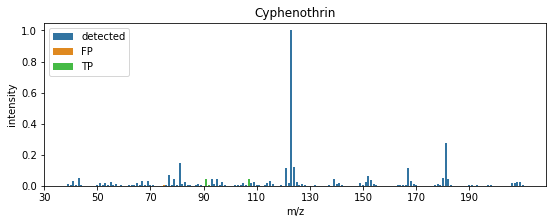

23073 0.1


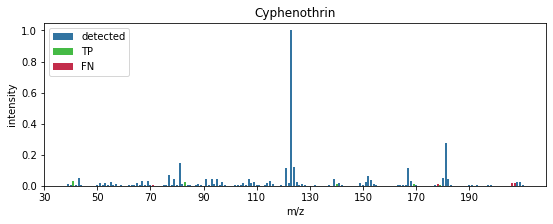

23073 0.15


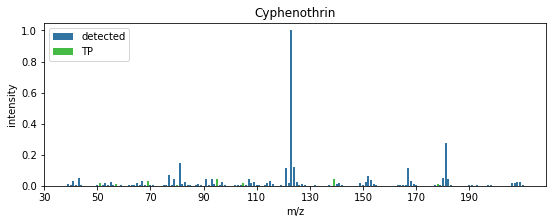

23073 0.2


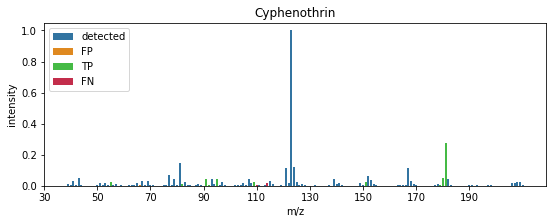

23073 0.25


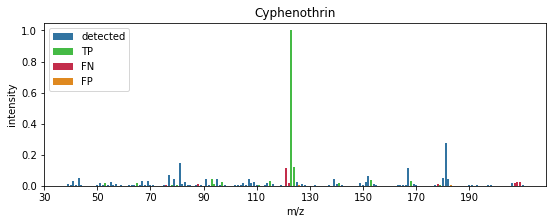

23073 0.3


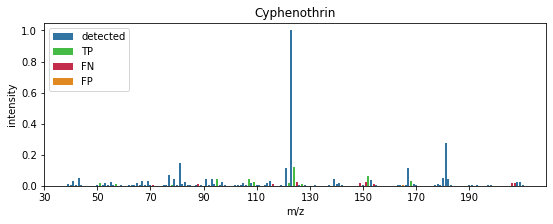

23073 0.35


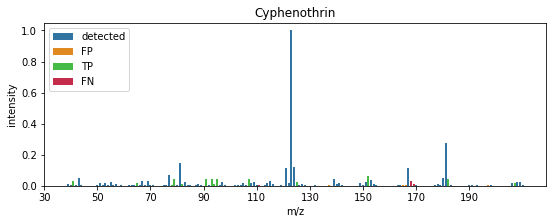

23073 0.4


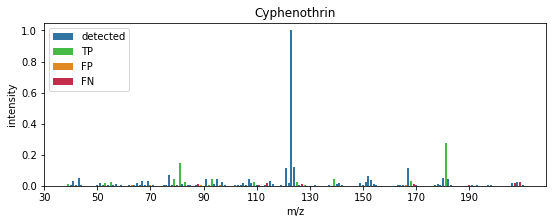

23073 0.45


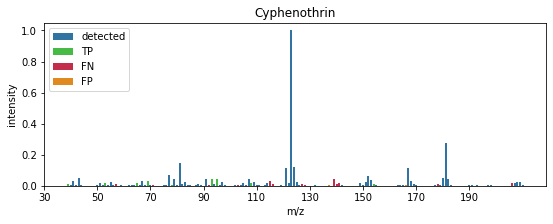

23073 0.5


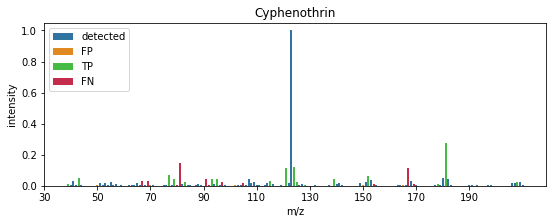

27346 0


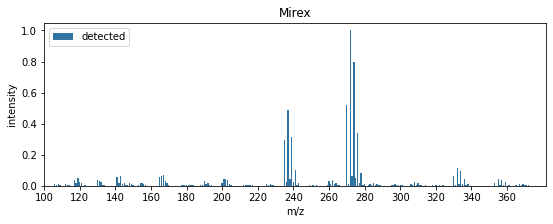

27346 0.05


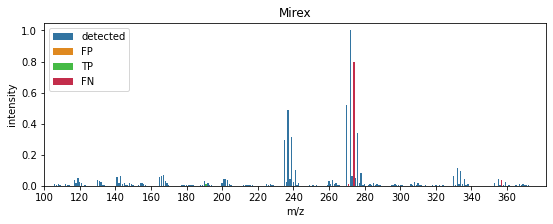

27346 0.1


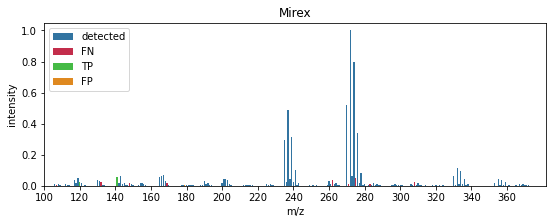

27346 0.15


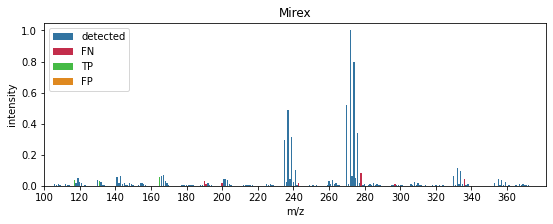

27346 0.2


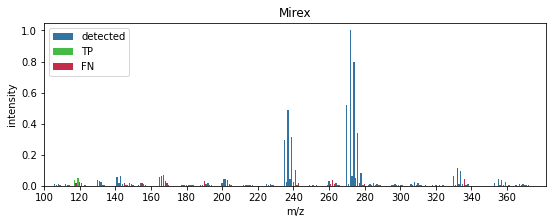

27346 0.25


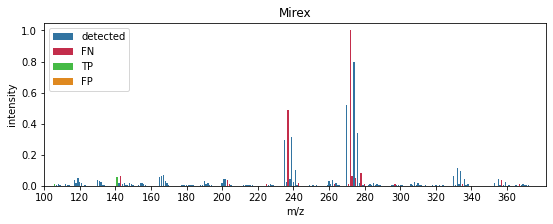

27346 0.3


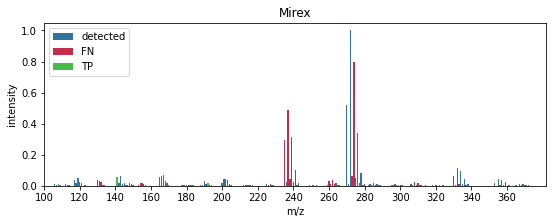

27346 0.35


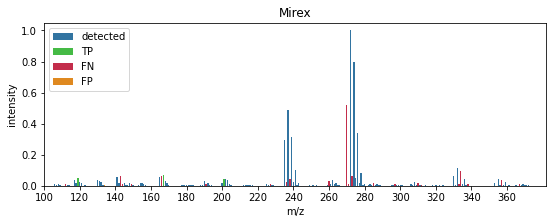

27346 0.4


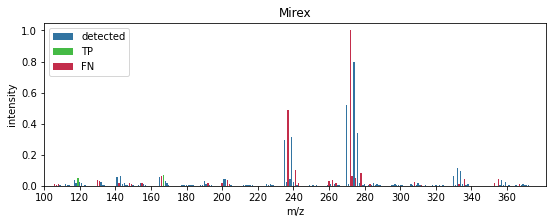

27346 0.45


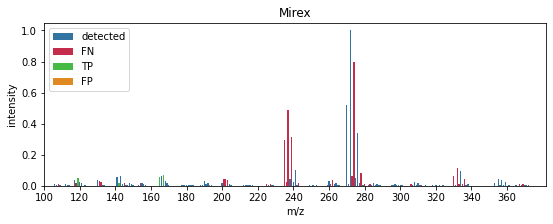

27346 0.5


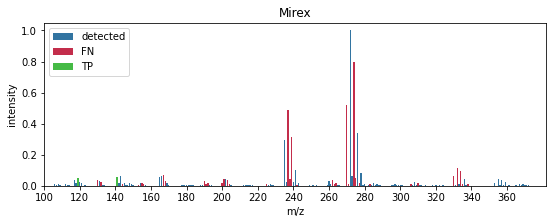

27347 0


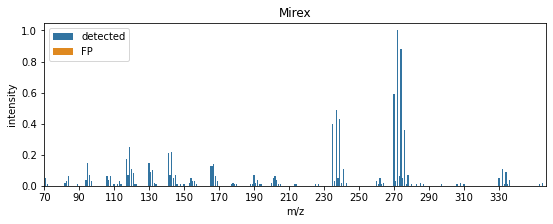

27347 0.05


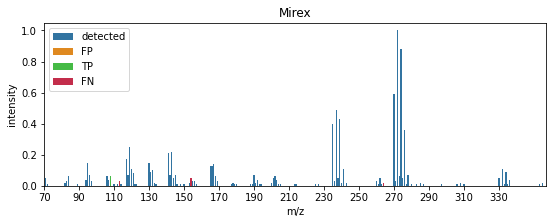

27347 0.1


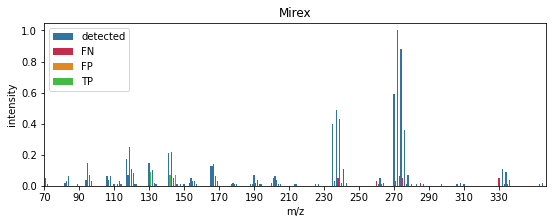

27347 0.15


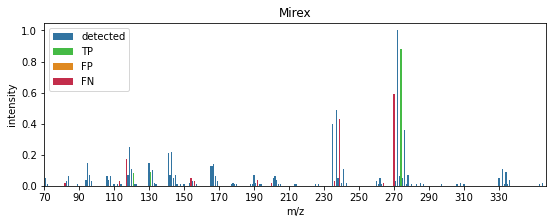

27347 0.2


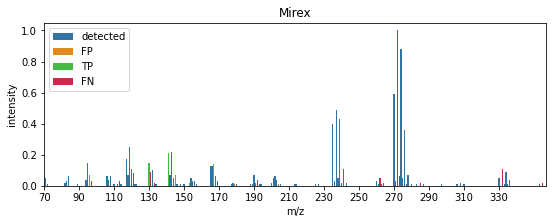

27347 0.25


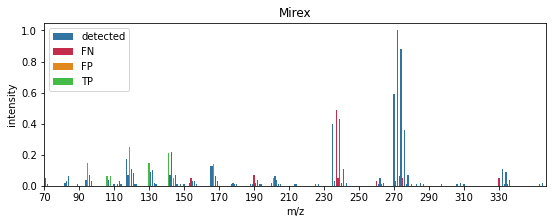

27347 0.3


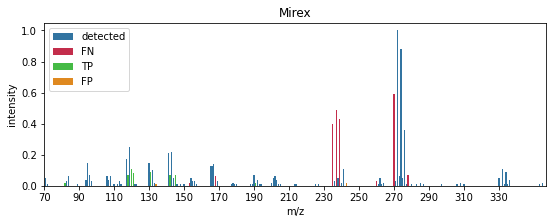

27347 0.35


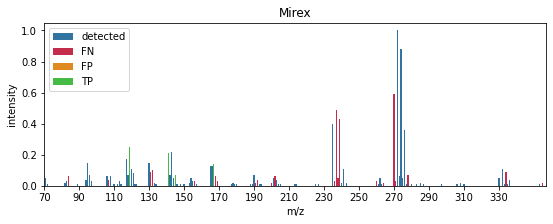

27347 0.4


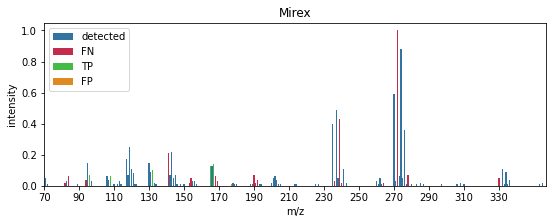

27347 0.45


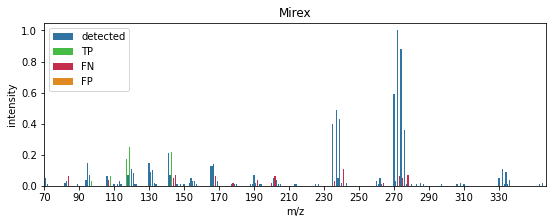

27347 0.5


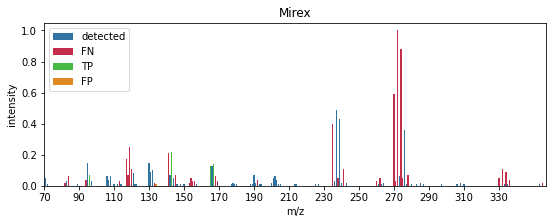

27348 0


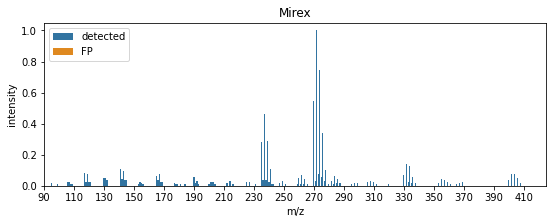

27348 0.05


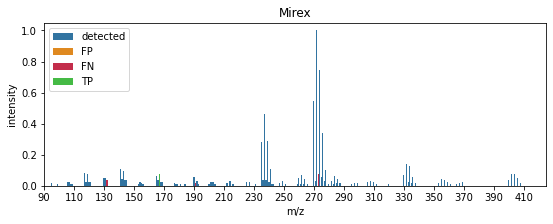

27348 0.1


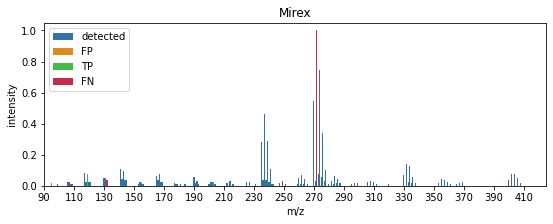

27348 0.15


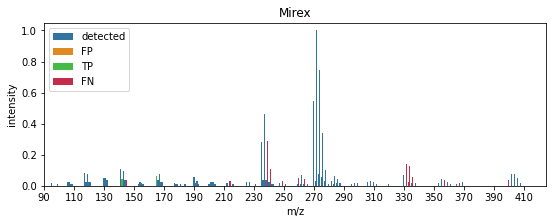

27348 0.2


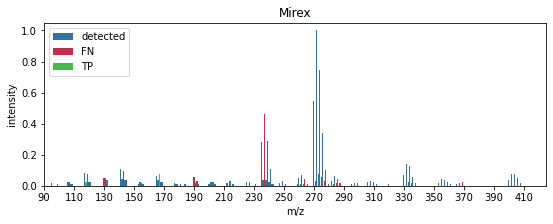

27348 0.25


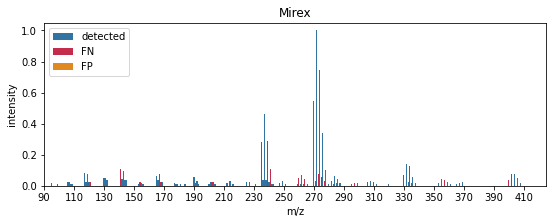

27348 0.3


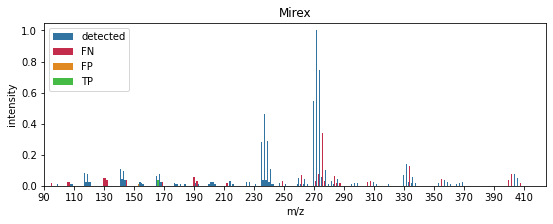

27348 0.35


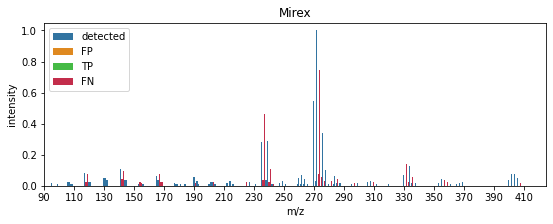

27348 0.4


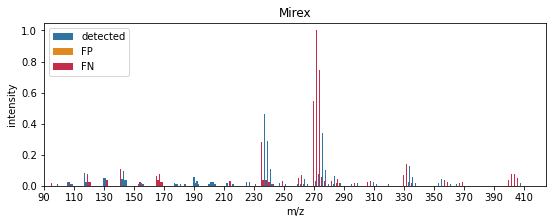

27348 0.45


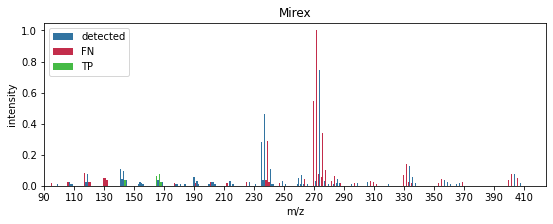

27348 0.5


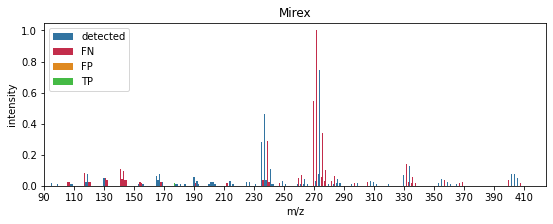

27349 0


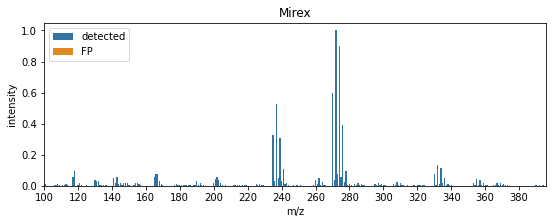

27349 0.05


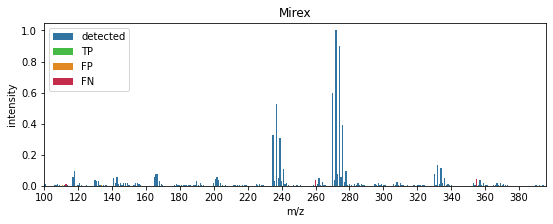

27349 0.1


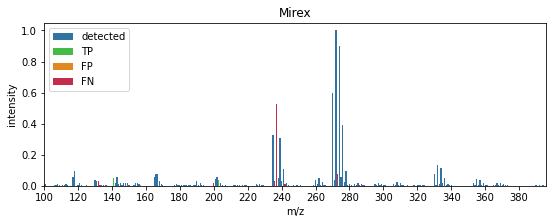

27349 0.15


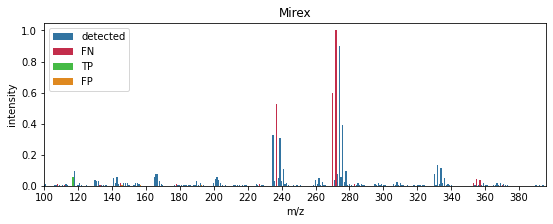

27349 0.2


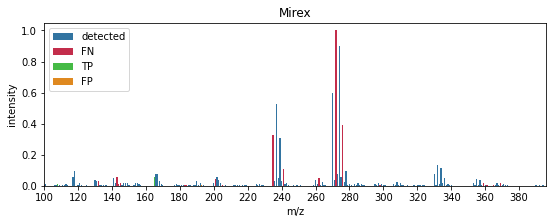

27349 0.25


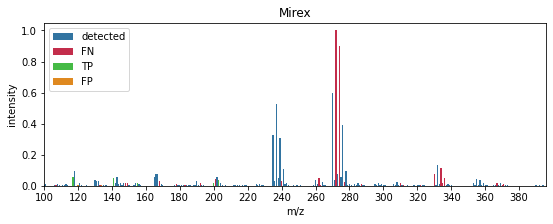

27349 0.3


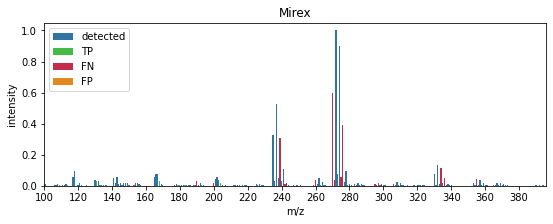

27349 0.35


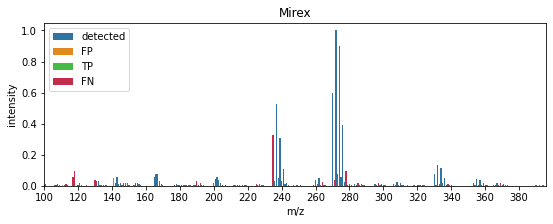

27349 0.4


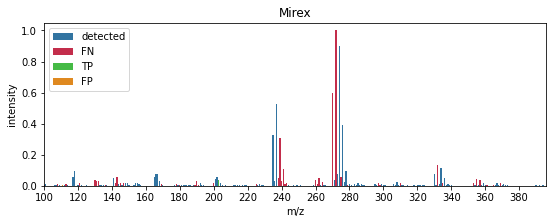

27349 0.45


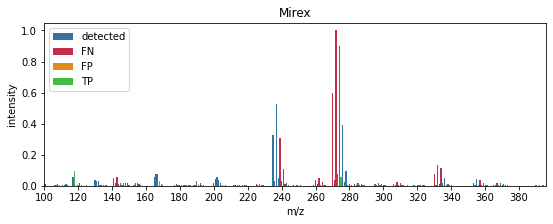

27349 0.5


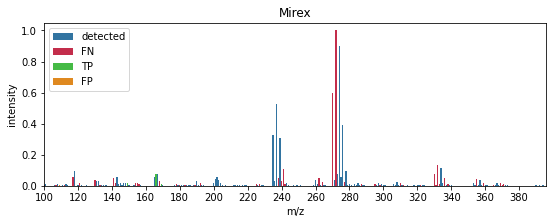

In [32]:
interesting =  ["Metobromuron", "Picoxystrobin", "Cyphenothrin", "Mirex"]
for i in range(len(datasets_denovo["fixed_test"])):
    if datasets_denovo["fixed_test"].spectrums[i].metadata["name"] in interesting:
        for k in range(len(probs)):
            print(i,probs[k])
            plot_beauty(datasets_denovo["fixed_test"].spectrums, i, k, preds, ys, i2e, kind="de_novo", kw="mlp", topk=False)

# Plot example spectra

In [55]:
from visual_utils import plot_spectrum_sample, plot_spectrum_sample_missing, plot_spectrum_sample_prediction, plot_spectrum_sample_metric

In [20]:
datasets_indb["spec_test"][13766].peaks.intensities
np.argsort(datasets_indb["spec_test"][13766].peaks.intensities)[::-1]

array([57, 54, 39, 45, 26, 40, 41, 16, 20, 52, 30, 58, 56, 51, 50, 35, 23,
       12, 55, 48, 22,  2, 33, 13, 17, 53,  1, 36, 24,  8, 18, 28, 37, 11,
       60, 25, 42, 46, 32, 49,  7, 27,  4, 38, 14, 10, 21,  6, 44,  5, 47,
        0, 31, 19, 43, 15,  9, 29, 34,  3, 59])

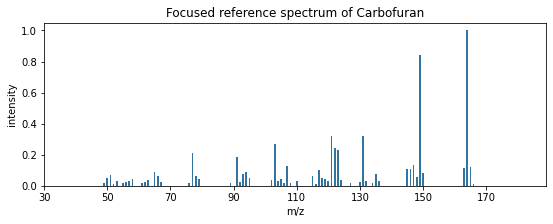

In [65]:
plot_spectrum_sample(datasets_indb["spec_test"][13766], max_mz=1001, save_to_path="figures/carbofuran.pdf")

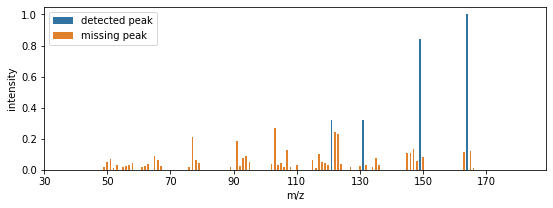

In [45]:
k=4
missing_ind = np.argsort(datasets_indb["spec_test"][13766].peaks.intensities)[::-1][k:]
missing_mz = datasets_indb["spec_test"][13766].peaks.mz[missing_ind]
plot_spectrum_sample_missing(datasets_indb["spec_test"][13766], missing_mz, max_mz=1001, save_to_path="figures/carbofuran_topk.pdf")

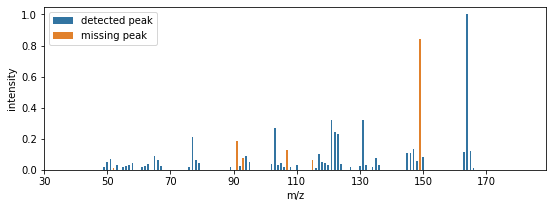

In [63]:
plot_spectrum_sample_missing(datasets_indb["spec_test"][13766], np.array([52,91,93,107,115, 149]), max_mz=1001, save_to_path="figures/carbofuran_rand.pdf")

{65.0, 163.0, 165.0, 135.0, 103.0, 107.0, 123.0, 77.0, 145.0, 146.0, 147.0, 51.0, 117.0, 150.0, 122.0, 91.0, 93.0, 94.0}


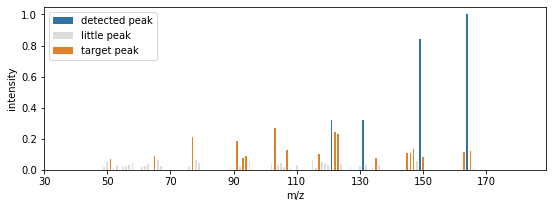

In [58]:
k=4
missing_ind = np.argsort(datasets_indb["spec_test"][13766].peaks.intensities)[::-1][k:]
missing_mz = datasets_indb["spec_test"][13766].peaks.mz[missing_ind]
last_int = np.sort(datasets_indb["spec_test"][13766].peaks.intensities)[::-1][k-1]
little_ind = np.nonzero(datasets_indb["spec_test"][13766].peaks.intensities <= last_int*0.2)
little_mz = datasets_indb["spec_test"][13766].peaks.mz[little_ind]

print(set(missing_mz).difference(set(little_mz)))
plot_spectrum_sample_metric(datasets_indb["spec_test"][13766], missing_mz=missing_mz, little_mz=little_mz, max_mz=1001, save_to_path="figures/carbofuran_topk_metric.pdf")

{65.0, 163.0, 165.0, 135.0, 103.0, 107.0, 123.0, 77.0, 145.0, 146.0, 147.0, 51.0, 117.0, 150.0, 122.0, 91.0, 93.0, 94.0}


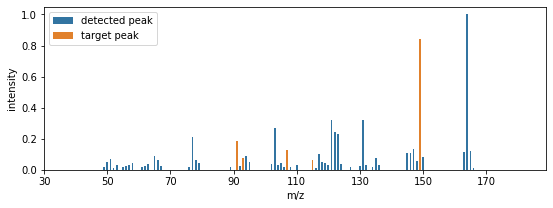

In [62]:
k=4
missing_ind = np.argsort(datasets_indb["spec_test"][13766].peaks.intensities)[::-1][k:]
missing_mz = datasets_indb["spec_test"][13766].peaks.mz[missing_ind]
last_int = np.sort(datasets_indb["spec_test"][13766].peaks.intensities)[::-1][k-1]
little_ind = np.nonzero(datasets_indb["spec_test"][13766].peaks.intensities <= last_int*0.2)
little_mz = datasets_indb["spec_test"][13766].peaks.mz[little_ind]

print(set(missing_mz).difference(set(little_mz)))
plot_spectrum_sample_metric(datasets_indb["spec_test"][13766], missing_mz=[91,93,107,115, 149], little_mz=[], max_mz=1001, save_to_path="figures/carbofuran_rand_metric.pdf")

In [23]:
rcx_path = "data/recetox_gc-ei_ms_20201028.msp"

In [77]:
spectrums_rcx = get_spectra(rcx_path)
spectrums_left = get_spectra(f"{base}/{dataset}/left/train.msp")

## Get same


In [70]:
inchi_indb = ["".join(spec.metadata["inchikey"].split("-")[:3]) for spec in  datasets_indb["spec_test"]]

In [71]:
inchi_dn = ["".join(spec.metadata["inchikey"].split("-")[:3]) for spec in  datasets_denovo["spec_test"]]

In [78]:
inchi_rcx = ["".join(spec.metadata["inchikey"].split("-")[:3]) for spec in  spectrums_rcx]

In [79]:
inchi_left = ["".join(spec.metadata["inchikey"].split("-")[:3]) for spec in  spectrums_left]

In [80]:
inchi_dn[0]

'CCGKOQOJPYTBIHUHFFFAOYSAN'

In [97]:
common = set(inchi_dn).intersection(inchi_rcx)
common

{'CIFWZNRJIBNXREUHFFFAOYSAN',
 'DNRJTBAOUJJKDYUHFFFAOYSAN',
 'DSSYKIVIOFKYAUUHFFFAOYSAN',
 'FJDPATXIBIBRIMUHFFFAOYSAN',
 'GVYLCNUFSHDAAWUHFFFAOYSAN',
 'HAXBIWFMXWRORIUHFFFAOYSAN',
 'HHXNVASVVVNNDGUHFFFAOYSAN',
 'HZRSNVGNWUDEFXUHFFFAOYSAN',
 'IBSNKSODLGJUMQSDNWHVSQSAN',
 'ISAVYTVYFVQUDYUHFFFAOYSAN',
 'JXVIIQLNUPXOIIUHFFFAOYSAN',
 'LAHWLEDBADHJGAUHFFFAOYSAN',
 'LMVPQMGRYSRMIWKRWDZBQOSAN',
 'ONKNPOPIGWHAQCUHFFFAOYSAN',
 'OPKYDBFRKPQCBSUHFFFAOYSAN',
 'SDKQRNRRDYRQKYUHFFFAOYSAN',
 'VPUGDVKSAQVFFSUHFFFAOYSAN',
 'WBHQEUPUMONIKFUHFFFAOYSAN',
 'WLFDQEVORAMCIMUHFFFAOYSAN'}

In [92]:
com = set(inchi_rcx).intersection(inchi_left)
com

{'APQSQLNWAIULLKUHFFFAOYSAN',
 'DDUIUBPJPOKOMVUHFFFAOYSAN',
 'DQZCVNGCTZLGAQUHFFFAOYSAN',
 'FIAXCDIQXHJNIXUHFFFAOYSAN',
 'FNELVJVBIYMIMCUHFFFAOYSAN',
 'JUVIOZPCNVVQFOHBGVWJBISAN',
 'RZLXIANUDLLFHNUHFFFAOYSAN',
 'WVQBLGZPHOPPFOUHFFFAOYSAN',
 'ZQEIXNIJLIKNTDUHFFFAOYSAN'}

In [99]:
import matplotlib.pyplot as plt
for spec in spectrums_left:
    if "".join(spec.metadata["inchikey"].split("-")[:3]) in com:
        #spec.plot()
        print(spec.metadata["name"])
        #plt.show()
        print(i)

Naphthalene, 1,4-dimethyl-
Naphthalene, 1,4-dimethyl-
Naphthalene, 1,4-dimethyl-
Cycluron
Cycluron
Cycluron
Methoprotryne
Methoprotryne
Methoprotryne
Metalaxyl
Metalaxyl
Metalaxyl
Metalaxyl
Metalaxyl
Metalaxyl
Metolachlor
Metolachlor
Metolachlor
Metolachlor
Rotenone
Rotenone
Rotenone
Ethiprole
Cyclooctane, 1,2,5,6-tetrabromo-
Cyclooctane, 1,2,5,6-tetrabromo-
Benzene, pentabromoethyl-
Benzene, pentabromoethyl-
Benzene, pentabromoethyl-


Picoxystrobin


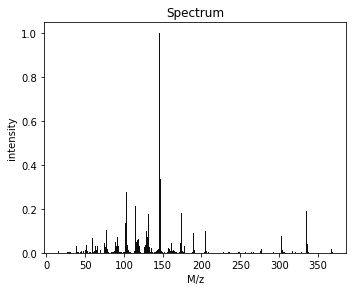

Picoxystrobin


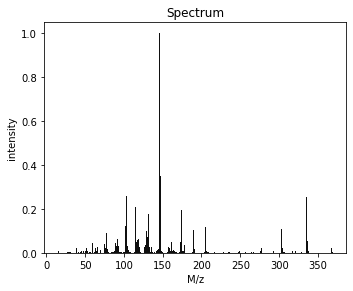

Picoxystrobin


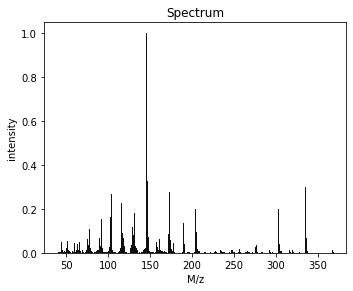

Picoxystrobin


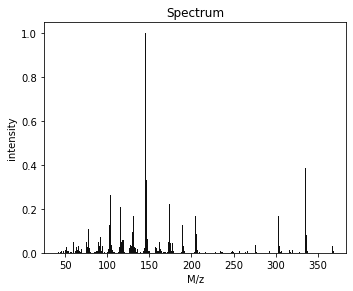

In [122]:
import matplotlib.pyplot as plt
for spec in datasets_denovo["spec_test"]:
    if spec.metadata["name"] == "Picoxystrobin":
        spec.plot()
        print(spec.metadata["name"])
        plt.show()


In [100]:
import matplotlib.pyplot as plt
for spec in datasets_denovo["spec_test"]:
    if "".join(spec.metadata["inchikey"].split("-")[:3]) in common:
        
        #spec.plot()
        print(spec.metadata["name"])
        #plt.show()

Camphor
Camphor
Camphor
Camphor
Camphor
Bicyclo[2.2.1]heptan-2-one, 1,7,7-trimethyl-, (1S)-
Bicyclo[2.2.1]heptan-2-one, 1,7,7-trimethyl-, (1S)-
Bicyclo[2.2.1]heptan-2-one, 1,7,7-trimethyl-, (1S)-
Phenol, 4-(1,1,3,3-tetramethylbutyl)-
Phenol, 4-(1,1,3,3-tetramethylbutyl)-
Phenol, 4-(1,1,3,3-tetramethylbutyl)-
Phenol, 4-(1,1,3,3-tetramethylbutyl)-
Dioxacarb
Dioxacarb
Dioxacarb
Mepanipyrim
Urea, N-(2-methylcyclohexyl)-N'-phenyl-
Urea, N-(2-methylcyclohexyl)-N'-phenyl-
Benzo[k]fluoranthene
Benzo[k]fluoranthene
Benzo[k]fluoranthene
Benzo[k]fluoranthene
Tonalid
Tonalid
Cyclopenta[g]-2-benzopyran, 1,3,4,6,7,8-hexahydro-4,6,6,7,8,8-hexamethyl-
Cyclopenta[g]-2-benzopyran, 1,3,4,6,7,8-hexahydro-4,6,6,7,8,8-hexamethyl-
Cyclopenta[g]-2-benzopyran, 1,3,4,6,7,8-hexahydro-4,6,6,7,8,8-hexamethyl-
Cyclopenta[g]-2-benzopyran, 1,3,4,6,7,8-hexahydro-4,6,6,7,8,8-hexamethyl-
Metobromuron
Metobromuron
Metobromuron
Coronene
Coronene
Fenamidone
1,1'-Biphenyl, 2,2',3,4,5'-pentachloro-
1,1'-Biphenyl, 2,2',3,4,5'

In [101]:
import matplotlib.pyplot as plt
for spec in datasets_indb["spec_test"]:
    if "".join(spec.metadata["inchikey"].split("-")[:3]) in common:
        #spec.plot()
        print(spec.metadata["name"])
        #plt.show()

Phenol, 4-(1,1,3,3-tetramethylbutyl)-
Phenol, 4-(1,1,3,3-tetramethylbutyl)-
Phenol, 4-(1,1,3,3-tetramethylbutyl)-
Dioxacarb
Dioxacarb
Benzo[k]fluoranthene
Benzo[k]fluoranthene
Benzo[k]fluoranthene
Tonalid
Cyclopenta[g]-2-benzopyran, 1,3,4,6,7,8-hexahydro-4,6,6,7,8,8-hexamethyl-
Cyclopenta[g]-2-benzopyran, 1,3,4,6,7,8-hexahydro-4,6,6,7,8,8-hexamethyl-
Cyclopenta[g]-2-benzopyran, 1,3,4,6,7,8-hexahydro-4,6,6,7,8,8-hexamethyl-
Metobromuron
Metobromuron
1,1'-Biphenyl, 2,2',4,5,5'-pentachloro-
1,1'-Biphenyl, 2,2',4,5,5'-pentachloro-
Pyraclostrobine
1,1'-Biphenyl, 2,2',3,3',4,5,6,6'-octachloro-


In [103]:
common = set(inchi_indb).intersection(inchi_rcx)

In [106]:
names = set()
import matplotlib.pyplot as plt
for spec in datasets_indb["spec_test"]:
    if "".join(spec.metadata["inchikey"].split("-")[:3]) in common:
        #spec.plot()
        print(spec.metadata["name"])
        #plt.show()
        names.add(spec.metadata["name"])

Benzyl alcohol
Benzyl alcohol
Benzyl alcohol
Limonene
Limonene
Limonene
Cyclohexene, 1-methyl-4-(1-methylethenyl)-, trans-
Cyclohexene, 1-methyl-4-(1-methylethenyl)-, trans-
Benzenemethanol, 4-methoxy-
Benzenemethanol, 4-methoxy-
Benzenemethanol, 4-methoxy-
Benzenemethanol, 4-methoxy-
Benzenemethanol, 4-methoxy-
Naphthalene, 1-fluoro-
Naphthalene, 1-fluoro-
Naphthalene, 1-fluoro-
Coumarin
Coumarin
Coumarin
Coumarin
Eucalyptol
Eucalyptol
Eucalyptol
Eucalyptol
Acenaphthene
Acenaphthene
Acenaphthene
Naphthalene, 1,2-dimethyl-
Naphthalene, 1,2-dimethyl-
Naphthalene, 1,2-dimethyl-
Naphthalene, 2,6-dimethyl-
Naphthalene, 2,6-dimethyl-
Naphthalene, 2,6-dimethyl-
Naphthalene, 1,8-dimethyl-
Naphthalene, 1,8-dimethyl-
Naphthalene, 1,3-dimethyl-
Naphthalene, 1,3-dimethyl-
Naphthalene, 1,3-dimethyl-
1,4-Naphthalenedione
1,4-Naphthalenedione
1,4-Naphthalenedione
Eugenol
Eugenol
Eugenol
Eugenol
Eugenol
7-Benzofuranol, 2,3-dihydro-2,2-dimethyl-
7-Benzofuranol, 2,3-dihydro-2,2-dimethyl-
7-Benzofuranol

In [108]:
for name in names:
    print(name)

Naphthalene, 2,6-dimethyl-
Coumarin
2,3',4,4',5',6-Hexachloro-1,1'-biphenyl
Vamidothion
1,4-Naphthalenedione
Pyraclostrobine
1,1-Dichloro-2,2-bis(p-chlorophenyl)ethane
1,1'-Biphenyl, 2,2',3,3',4,4',5-heptachloro-
Tri(2-chloroethyl) phosphate
Simetryn
Dibenzo[def,mno]chrysene
Naphthalene, 1,2-dimethyl-
Perylene-D12
Phosphorodithioic acid, S-[(tert-butylthio)methyl] O,O-diethyl ester
Benzyl Benzoate
Flufenacet
Limonene
Pyrene
Tebufenpyrad
1,1'-Biphenyl, 2,2',3,5,5',6-hexachloro-
Eucalyptol
Progesterone
2,2',3,4,4',5',6-Heptabromodiphenyl ether
4H-Inden-4-one, 1,2,3,5,6,7-hexahydro-1,1,2,3,3-pentamethyl-
Botran
Dicrotophos
Benalaxyl
Benzenemethanol, 4-methoxy-
p-Terphenyl
Cyclopropanecarboxylic acid, 2,2-dimethyl-3-(2-methyl-1-propenyl)-, 2-methyl-4-oxo-3-(2-propenyl)-2-cyclopenten-1-yl ester, (1R,3R)-rel-
Mevinphos
Difluron
Naphthalene, 1-fluoro-
Heptachlor
Propargite
2,2',3,4',5-Pentachloro-1,1'-biphenyl
Benzo[a]pyrene
Spiroxamine
Mepronil
Penconazole
Ethinyl Estradiol
Cypermethrin
Cycl

In [109]:
common = set(inchi_left).intersection(inchi_rcx)

In [110]:
names = set()
import matplotlib.pyplot as plt
for spec in spectrums_left:
    if "".join(spec.metadata["inchikey"].split("-")[:3]) in common:
        #spec.plot()
        print(spec.metadata["name"])
        #plt.show()
        names.add(spec.metadata["name"])

Naphthalene, 1,4-dimethyl-
Naphthalene, 1,4-dimethyl-
Naphthalene, 1,4-dimethyl-
Cycluron
Cycluron
Cycluron
Methoprotryne
Methoprotryne
Methoprotryne
Metalaxyl
Metalaxyl
Metalaxyl
Metalaxyl
Metalaxyl
Metalaxyl
Metolachlor
Metolachlor
Metolachlor
Metolachlor
Rotenone
Rotenone
Rotenone
Ethiprole
Cyclooctane, 1,2,5,6-tetrabromo-
Cyclooctane, 1,2,5,6-tetrabromo-
Benzene, pentabromoethyl-
Benzene, pentabromoethyl-
Benzene, pentabromoethyl-


In [111]:
for name in names:
    print(name)

Benzene, pentabromoethyl-
Metalaxyl
Metolachlor
Ethiprole
Rotenone
Methoprotryne
Cycluron
Cyclooctane, 1,2,5,6-tetrabromo-
Naphthalene, 1,4-dimethyl-


In [112]:
inchi_indb_val = ["".join(spec.metadata["inchikey"].split("-")[:3]) for spec in  datasets_indb["spec_val"]]

In [113]:
inchi_dn_val = ["".join(spec.metadata["inchikey"].split("-")[:3]) for spec in  datasets_denovo["spec_val"]]

In [114]:
common = set(inchi_dn_val).intersection(inchi_indb_val).intersection(inchi_rcx)
common

{'DSKJPMWIHSOYEAUHFFFAOYSAN',
 'GYSSRZJIHXQEHQUHFFFAOYSAN',
 'HAWJXYBZNNRMNOUHFFFAOYSAN',
 'IAKOZHOLGAGEJTUHFFFAOYSAN',
 'IYAZLDLPUNDVAGUHFFFAOYSAN',
 'JWBOIMRXGHLCPPUHFFFAOYSAN',
 'LQDARGUHUSPFNLUHFFFAOYSAN',
 'MVWHGTYKUMDIHLUHFFFAOYSAN',
 'UCNVFOCBFJOQALUHFFFAOYSAN',
 'YEUHHUCOSQOCIXUHFFFAOYSAN'}

In [118]:
import matplotlib.pyplot as plt
for spec in datasets_denovo["spec_val"]:
    if "".join(spec.metadata["inchikey"].split("-")[:3]) in common:
        #spec.plot()
        print(spec.metadata["name"])
        #plt.show()
        # print(i)

Benzo[b]naphtho[2,1-d]thiophene
Benzo[b]naphtho[2,1-d]thiophene
Benzo[b]naphtho[2,1-d]thiophene
Benzo[b]naphtho[2,1-d]thiophene
Carboxin
Carboxin
5-Butyl-2-ethylamino-6-methylpyrimidin-4-yl dimethylsulfamate
5-Butyl-2-ethylamino-6-methylpyrimidin-4-yl dimethylsulfamate
5-Butyl-2-ethylamino-6-methylpyrimidin-4-yl dimethylsulfamate
5-Butyl-2-ethylamino-6-methylpyrimidin-4-yl dimethylsulfamate
p,p'-DDE
p,p'-DDE
p,p'-DDE
p,p'-DDE
p,p'-DDE
p,p'-DDE
Mitotane
Mitotane
Mitotane
Mitotane
Mitotane
2-((2H-benzotriazo)-2-yl)-4-(1,1,3,3-tetramethylbutyl)phenol
2-((2H-benzotriazo)-2-yl)-4-(1,1,3,3-tetramethylbutyl)phenol
Octrizole
Methoxychlor
Methoxychlor
Methoxychlor
Methoxychlor
Methoxychlor
Methoxychlor
1,1'-Biphenyl, 2,2',4,4',5,5'-hexachloro-
1,1'-Biphenyl, 2,2',4,4',5,5'-hexachloro-
Tetraconazole
Tetraconazole
Furathiocarb
Furathiocarb
Furathiocarb
